# Imports

In [ ]:
!conda activate py37
!pip install music21

Traceback (most recent call last):
  File "/Users/lstrika/anaconda2/bin/conda", line 13, in <module>
    sys.exit(main())
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/cli/main.py", line 149, in main
    from ..exceptions import conda_exception_handler
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/exceptions.py", line 19, in <module>
    from ._vendor.auxlib.entity import EntityEncoder
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/entity.py", line 253, in <module>
    from .collection import AttrDict, frozendict, make_immutable
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/collection.py", line 10, in <module>
    from .compat import isiterable, iteritems, odict, text_type
  File "/Users/lstrika/anaconda2/lib/python2.7/site-packages/conda/_vendor/auxlib/compat.py", line 10, in <module>
    from ._vendor.five import WhateverIO as StringIO, with_metaclass
  File "/Users/lstrik

In [1]:
from music21 import *
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model

# Config variables

In [3]:
path = "gwern/midis"
frequent_notes_threshold = 50

n_of_timesteps = 32
evaluation_percentage = 0.2 # 20% of the data will be used as evaluation

output_dimension = 100
kernel_size = 3
epochs = 50

len_of_predictions = 30

# Aux functions

In [1]:
def read_midi(file):
    
    print("Reading: " + file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    try:
        midi = converter.parse(file)
    except:
        return np.array([])
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    if not s2:
        return np.array([])
    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [5]:
def convert_to_midi(prediction_output, filename):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
    

# Core code

## Read files

In [6]:
from glob import glob
from multiprocess import Pool
import time


TRAINING_SET_SIZE = 1024
NTHREADS = 32

files = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.mid'))]
print(len(files))
start = time.time()
#files=[i for i in os.listdir(path) if i.endswith(".mid")]
with Pool(NTHREADS) as p:
    notes_array = p.map(read_midi, files[:TRAINING_SET_SIZE])

print('filtering...')
notes_array = [e for e in notes_array if e != np.array([])]

notes_array = np.array(notes_array, dtype=object)
print('notes...')
notes_ = [element for note_ in notes_array for element in note_]
end = time.time()

print(f'took {end - start} seconds')

77152
Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/fa09fc4cc12b6f2d085ecb98650d2de6.midReading: gwern/midis/lmd_matched/R/R/I/TRRRION128F145EBB7/9048c4045d7d8b2837f3725d7995dc1c.midReading: gwern/midis/lmd_matched/R/R/I/TRRRILO128F422FFED/0ec315d7be357f130de5206e67c33b36.midReading: gwern/midis/lmd_matched/R/R/U/TRRRUFD12903CD7092/6ca2a1f03a193c336e18e86b5d845f34.midReading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ef6b163c2a5d18dbffa3b24aaf21419d.mid




Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/6a4b5d29cecc86c2078f93edc8866299.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=0, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ee79e6b07b5bd944a4571918cdee715b.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=2, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(


Reading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/9f9c81dd249087150c9eac829c0f7c89.mid
Reading: gwern/midis/lmd_matched/R/R/N/TRRRNPV128F42AAA55/b9dc31daae7e35deffae077a705e01e7.mid
Reading: gwern/midis/lmd_matched/R/R/N/TRRRNGS12903CD16D9/18e05979f4132614733c340185809dee.mid


/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=16, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=17, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=18, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/local/lib/python3.9/site-packages/music21/midi/translate.py:790: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent PROGRAM_CHANGE, track=19, channel=10, data=0>; getting generic UnpitchedPercussion
  warnings.warn(
/usr/loc

filtering...
notes...
took 39.8263201713562 seconds


/var/folders/xy/dzytbyv51dd88zf00d9qj1100000gn/T/ipykernel_6522/2862025795.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  notes_array = [e for e in notes_array if e != np.array([])]
/var/folders/xy/dzytbyv51dd88zf00d9qj1100000gn/T/ipykernel_6522/2862025795.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  notes_array = [e for e in notes_array if e != np.array([])]


In [7]:
notes_array.shape

(5,)

In [8]:
np.array([t.shape for t in notes_array]).mean()

485.8

## Analyze data

In [9]:
unique_notes = list(set(notes_))
print(len(unique_notes))

145


(array([101.,  20.,  12.,   7.,   1.,   2.,   0.,   1.,   0.,   1.]),
 array([  1. ,  16.9,  32.8,  48.7,  64.6,  80.5,  96.4, 112.3, 128.2,
        144.1, 160. ]),
 <BarContainer object of 10 artists>)

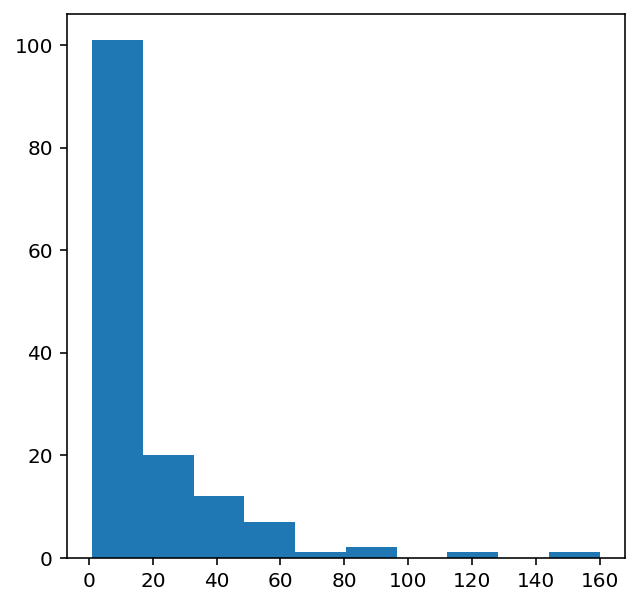

In [10]:
# Notes frequency
freq = dict(Counter(notes_))

no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

## Preparing data

In [11]:
frequent_notes = [note_ for note_, count in freq.items() if count>=frequent_notes_threshold]

# Get the same dataset only with frequent notes
new_music=[]

for notes in notes_array:
    new_music.append([note for note in notes if note in frequent_notes])
    
new_music = np.array(new_music, dtype=object)

In [12]:
inputs = []
outputs = []

for notes_ in new_music:
    for i in range(0, len(notes_) - n_of_timesteps, 1):
        
        inputs.append(notes_[i:i + n_of_timesteps])
        outputs.append(notes_[i + n_of_timesteps])
        
inputs=np.array(inputs)
outputs=np.array(outputs)

In [13]:
unique_inputs = list(set(inputs.ravel()))
input_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_inputs))

input_seq=[]
for input_ in inputs:
    input_seq.append([input_note_to_int[note_] for note_ in input_])
    
input_seq = np.array(input_seq)

In [14]:
unique_outputs = list(set(outputs))
output_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_outputs)) 
output_seq = np.array([output_note_to_int[note_] for note_ in outputs])

## Split data into training and evaluation

In [15]:
input_training, input_validation, output_training, output_validation = train_test_split(input_seq,output_seq,test_size=evaluation_percentage,random_state=0)

## Build model

In [16]:
# LSTM architecture. We will use WaveNet for now
# def lstm():
#   model = Sequential()
#   model.add(LSTM(128,return_sequences=True))
#   model.add(LSTM(128))
#   model.add(Dense(256))
#   model.add(Activation('relu'))
#   model.add(Dense(n_vocab))
#   model.add(Activation('softmax'))
#   model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
#   return model

In [17]:
K.clear_session()
model = Sequential()

# Parameters explanation: https://keras.io/api/layers/core_layers/embedding/
model.add(Embedding(len(unique_inputs), output_dimension, input_length=n_of_timesteps,trainable=True)) 

# Parameters explanation: https://keras.io/api/layers/convolution_layers/convolution1d/
model.add(Conv1D(n_of_timesteps*2*2,kernel_size, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(n_of_timesteps*4*2,kernel_size, activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(n_of_timesteps*8*2,kernel_size, activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())

# Parameters explanation: https://keras.io/api/layers/core_layers/dense/
# 256 -> 512
model.add(Dense(512, activation='relu'))
model.add(Dense(len(unique_outputs), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

2021-10-29 10:05:49.270015: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           1200      
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 128)           38528     
_________________________________________________________________
dropout (Dropout)            (None, 32, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 256)           98560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 256)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 256)            0

## Fit model

In [19]:
model_name = 'Gwern_big_model_1024.h5'
epochs = 50
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(input_training),np.array(output_training), batch_size=1024, epochs=epochs, validation_data=(np.array(input_validation),np.array(output_validation)),verbose=1, callbacks=[checkpoint])


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.4147 - val_loss: 2.4110

Epoch 00001: val_loss improved from inf to 2.41103, saving model to Gwern_big_model_1024.h5
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2.3755 - val_loss: 2.3860

Epoch 00002: val_loss improved from 2.41103 to 2.38602, saving model to Gwern_big_model_1024.h5
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 2.3705 - val_loss: 2.3644

Epoch 00003: val_loss improved from 2.38602 to 2.36444, saving model to Gwern_big_model_1024.h5
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 2.3322 - val_loss: 2.3399

Epoch 00004: val_loss improved from 2.36444 to 2.33991, saving model to Gwern_big_model_1024.h5
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 2.2828 - val_loss: 2.3106

Epoch 00005: val_loss improved from 2.33991 to 2.31060, saving model to Gwern_big_model_1024.h5
Epoch 6/10
1/1 [============================

In [20]:
model = load_model('Gwern_big_model_1024.h5')

## Generate music!

In [21]:
ind = np.random.randint(0,len(input_validation)-1)
print(ind)
random_music = input_validation[ind]
        
predictions=[]
for i in range(len_of_predictions):

    random_music = random_music.reshape(1,n_of_timesteps)

    prob   = model.predict(random_music)[0]
    
    output_pred = np.argmax(prob, axis=0)
    print(output_pred)
    predictions.append(output_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),output_pred)
    random_music = random_music[1:]
    

26
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


In [22]:
input_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_inputs)) 
predicted_notes = [input_int_to_note[i] for i in predictions]
print(predicted_notes)

['A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4', 'A4']


In [23]:
convert_to_midi(predicted_notes, 'gwern_music_small_1024_3.mid')

## Beam search

In [ ]:
import math

def beam_search_generator(starting_data, model, len_of_songs, k):
    n_of_timesteps = len(starting_data[0])
    
    # starting k randomly generated states
    indices = np.random.randint(len(starting_data), size=k)
    # [prediction, random_music, score]
    sequences = [[[], starting_data[index], 0.0] for index in indices]
    # walk over each step in sequence

    for _ in range(len_of_songs):
        assert(len(sequences) == k)
        all_candidates = list()
        all_random_music = [sequence[1] for sequence in sequences]
        all_random_music = np.array(all_random_music).reshape(k, n_of_timesteps)
        prob = model.predict(all_random_music)
        # expand each current candidate
        for i in range(k):
            seq, random_music, score = sequences[i]
            for j in range(len(prob[i])):
                assert(len(random_music) == n_of_timesteps)
                new_random_music = np.insert(random_music,len(random_music),j)
                new_random_music = new_random_music[1:]
                candidate = [seq + [j], new_random_music, score - math.log(prob[i][j])]
                all_candidates.append(candidate)

        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[2])
        # select k best
        sequences = ordered[:k]
    return sequences

In [25]:
# generate music with beam search
result = beam_search_generator(input_validation, model, len_of_predictions, 3)
# print generated songs
for seq in result:
    print(seq)

[[1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([2, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 41.43330583838211]
[[1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([2, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 41.56365799877024]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 41.75512872036035]


In [26]:
# print best song generated and save midi
predicted_notes = [input_int_to_note[i] for i in result[0][0]]
print(predicted_notes)
convert_to_midi(predicted_notes, 'gwern_music_small_1024_beam_search.mid')

['A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3']


## Perplexity

In [30]:
import numpy as np 


def get_predictions(model, song):
    N = len(song)
    predictions = []
    for i in range(1, N ):
        # Get the first i notes
        if i < 33:
            partial_song = song[:i]
        else:
            partial_song = song[i-31:i]
        # Pad it with zeroes to get 32 notes
        partial_song_with_padding = np.pad(partial_song, (max(32 - len(partial_song), 0), 0), 'constant', constant_values=0)
        
        # Evaluate it
        prob = model.predict(partial_song_with_padding.reshape(1, 32))
        if i == 34:
            print(prob)
        predictions.append(prob[0][song[i]])
    return predictions

def stable_perplexity(predictions):
    N = len(predictions)
    log_perplexity = 0
    for prob in predictions:
        log_perplexity += np.log(prob)
    return np.exp(-log_perplexity/float(N))

def default_perplexity(predictions):
    N = len(predictions)
    perplexity = 1
    for prob in predictions:
        perplexity*=prob
    return (1/perplexity)**(1/float(N))

def calculate_perplexity(model, song):
    return default_perplexity(get_predictions(model, song))

def calculate_perplexity_stable(model, song):    
    return stable_perplexity(get_predictions(model, song))


In [35]:
### Test perplexities
probs = np.random.random(500)
print(stable_perplexity(probs))
print(default_perplexity(probs))


2.6880580828615903
2.6880580828615908


In [111]:
# Calculate perplexity with random song
index = np.random.randint(len(input_validation))

print(calculate_perplexity(model, input_validation[index]))

1.6449214695973116e-33


In [2]:
from tensorflow.keras.models import load_model
import pickle
from glob import glob
from multiprocess import Pool
import time
import os
import os.path
from music21 import *

model_path = 'model_test_1024.h5'
dict_path = 'model_test_1024.h5_dict.pickle'
def read_midi(file):
    
    print("Reading: " + file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    try:
        midi = converter.parse(file)
    except:
        return np.array([])
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)
    if not s2:
        return np.array([])
    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

def feedforward(model_path, model_dict_path, test_path):
    model = load_model(model_path)
    note_to_num_dict = pickle.load( open( model_dict_path, "rb" ) )
    
    # make test dataset
    TEST_SET_SIZE = 128
    NTHREADS = 16

    
    files = [y for x in os.walk(test_path) for y in glob(os.path.join(x[0], '*.mid'))]
    print(len(files))
    start = time.time()
    #files=[i for i in os.listdir(path) if i.endswith(".mid")]
    with Pool(NTHREADS) as p:
        notes_array = p.map(read_midi, files[10000:10000+TEST_SET_SIZE])

    print('filtering...')
    notes_array = [e for e in notes_array if e != np.array([])]
    print(notes_array)
    notes_array = np.array(notes_array, dtype=object)
    print('notes...')
    
    end = time.time()
    print(f'took {end - start} seconds')
    input_seq=[]
    for input_ in notes_array:
        input_seq.append([note_to_num_dict[note_] for note_ in input_ if note_ in note_to_num_dict.keys()])

    input_seq = np.array(input_seq)
    end = time.time()
    print(f'took {end - start} seconds')
    
    return np.asarray([calculate_perplexity_stable(model, song) for song in input_seq])
    
#result = feedforward(model_path, dict_path, 'gwern/midis')
#result

In [3]:
from music21 import *
model_path = 'model_test_1024.h5'
dict_path = 'model_test_1024.h5_dict.pickle'
model_dict_path = dict_path
test_path = 'gwern/midis/'

model = load_model(model_path)
note_to_num_dict = pickle.load( open( model_dict_path, "rb" ) )

# make test dataset
TEST_SET_SIZE = 32
NTHREADS = 16

files = [y for x in os.walk(test_path) for y in glob(os.path.join(x[0], '*.mid'))]
print(len(files))
print(files[:16])
start = time.time()
#files=[i for i in os.listdir(path) if i.endswith(".mid")]


2021-11-18 18:09:03.184002: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


77153
['gwern/midis/lmd_matched/R/R/U/TRRRUFD12903CD7092/6ca2a1f03a193c336e18e86b5d845f34.mid', 'gwern/midis/lmd_matched/R/R/I/TRRRILO128F422FFED/0ec315d7be357f130de5206e67c33b36.mid', 'gwern/midis/lmd_matched/R/R/I/TRRRION128F145EBB7/9048c4045d7d8b2837f3725d7995dc1c.mid', 'gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/fa09fc4cc12b6f2d085ecb98650d2de6.mid', 'gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ef6b163c2a5d18dbffa3b24aaf21419d.mid', 'gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/6a4b5d29cecc86c2078f93edc8866299.mid', 'gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ee79e6b07b5bd944a4571918cdee715b.mid', 'gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/9f9c81dd249087150c9eac829c0f7c89.mid', 'gwern/midis/lmd_matched/R/R/N/TRRRNPV128F42AAA55/b9dc31daae7e35deffae077a705e01e7.mid', 'gwern/midis/lmd_matched/R/R/N/TRRRNGS12903CD16D9/18e05979f4132614733c340185809dee.mid', 'gwern/midis/lmd_matched/R/R/N/TRRRNGS12903CD16D9/89c287bce7f330617e27c21ecc1861ab.mid', 'gwern/midis/l

In [4]:
with Pool(NTHREADS) as p:
    notes_array = p.map(read_midi, files[0:TEST_SET_SIZE])

Reading: gwern/midis/lmd_matched/R/R/U/TRRRUFD12903CD7092/6ca2a1f03a193c336e18e86b5d845f34.midReading: gwern/midis/lmd_matched/R/R/I/TRRRION128F145EBB7/9048c4045d7d8b2837f3725d7995dc1c.midReading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/fa09fc4cc12b6f2d085ecb98650d2de6.midReading: gwern/midis/lmd_matched/R/R/I/TRRRILO128F422FFED/0ec315d7be357f130de5206e67c33b36.midReading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ef6b163c2a5d18dbffa3b24aaf21419d.midReading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/6a4b5d29cecc86c2078f93edc8866299.midReading: gwern/midis/lmd_matched/R/R/N/TRRRNPV128F42AAA55/b9dc31daae7e35deffae077a705e01e7.midReading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/9f9c81dd249087150c9eac829c0f7c89.midReading: gwern/midis/lmd_matched/R/R/I/TRRRIVC12903CA6C5A/ee79e6b07b5bd944a4571918cdee715b.midReading: gwern/midis/lmd_matched/R/R/N/TRRRNGS12903CD16D9/18e05979f4132614733c340185809dee.midReading: gwern/midis/lmd_matched/R/R/N/TRRRNGS12903CD16D9/89

In [5]:
notes_array

[array([], dtype=float64),
 array([], dtype=float64),
 array(['G6', 'F#6', 'D6', 'D6', 'G6', 'F#6', 'D6'], dtype='<U3'),
 array(['11.1.4', '4.9', 'E3', '11.1.4', 'E3', '9.1.4', 'A3', 'E3',
        '9.11.1.4', 'C#3', '6.9.1', 'D3', 'D4', 'D4', '6.9.1', 'D4', 'D4',
        'A3', 'D3', 'B3', 'A3', '11.1.4', 'A2', 'D3', 'D4', 'A3', 'E3',
        '11.1.4', 'E3', '9.1.4', 'A3', 'E3', '9.11.1.4', 'C#3', '6.9.1',
        'D3', 'D4', 'D4', 'D4', '6.9.1', 'D4', 'A3', 'A2', '11.4', 'E3',
        '11.1', '11.1', '11.1.4', 'E3', '9.1', 'A2', 'A3', 'E3', '9.1',
        'A3', '1.2.6.9', 'D3', 'A3', 'A3', '1.2.6.9', 'A3', '1.2.6.9',
        '1.2.6.9', 'A3', '8.11.1.4', 'G#3', 'C#3', '8.11.1.4', 'G#3',
        '6.9.11.2', 'B2', 'A3', 'A3', '6.9.11.2', 'A3', '8.9', '11.1.4',
        'E3', 'E3', '11', '1.4', '1.4', '9', '1.4', '11', '9', '1.4',
        '1.4', '11', '9.1.4', 'D3', '6.9.1', 'A3', 'D4', 'D4', '1.2.6.9',
        'A3', '1.2.6.9', '1.2.6.9', '9.2', '8.11.1.4', 'C#3', 'G#3',
        '8.11.1.4',

In [31]:

print(notes_array)
print('filtering...')
notes_array = [e for e in notes_array if e != np.array([])]
print(notes_array)
notes_array = np.array(notes_array, dtype=object)
print('notes...')
print(notes_array)
end = time.time()
print(f'took {end - start} seconds')
input_seq=[]
for input_ in notes_array:
    input_seq.append([note_to_num_dict[note_] for note_ in input_ if note_ in note_to_num_dict.keys()])


input_seq = np.array(input_seq)
print(input_seq)
end = time.time()
print(f'took {end - start} seconds')

perplexities = [calculate_perplexity_stable(model, song) for song in input_seq[:5] ]

[array(['G6', 'F#6', 'D6', 'D6', 'G6', 'F#6', 'D6'], dtype='<U3')
 array(['11.1.4', '4.9', 'E3', '11.1.4', 'E3', '9.1.4', 'A3', 'E3',
       '9.11.1.4', 'C#3', '6.9.1', 'D3', 'D4', 'D4', '6.9.1', 'D4', 'D4',
       'A3', 'D3', 'B3', 'A3', '11.1.4', 'A2', 'D3', 'D4', 'A3', 'E3',
       '11.1.4', 'E3', '9.1.4', 'A3', 'E3', '9.11.1.4', 'C#3', '6.9.1',
       'D3', 'D4', 'D4', 'D4', '6.9.1', 'D4', 'A3', 'A2', '11.4', 'E3',
       '11.1', '11.1', '11.1.4', 'E3', '9.1', 'A2', 'A3', 'E3', '9.1',
       'A3', '1.2.6.9', 'D3', 'A3', 'A3', '1.2.6.9', 'A3', '1.2.6.9',
       '1.2.6.9', 'A3', '8.11.1.4', 'G#3', 'C#3', '8.11.1.4', 'G#3',
       '6.9.11.2', 'B2', 'A3', 'A3', '6.9.11.2', 'A3', '8.9', '11.1.4',
       'E3', 'E3', '11', '1.4', '1.4', '9', '1.4', '11', '9', '1.4',
       '1.4', '11', '9.1.4', 'D3', '6.9.1', 'A3', 'D4', 'D4', '1.2.6.9',
       'A3', '1.2.6.9', '1.2.6.9', '9.2', '8.11.1.4', 'C#3', 'G#3',
       '8.11.1.4', 'G#3', 'F#2', '1.4.6.9', 'C#3', '1.4.6.9', 'C#3',
       '1.4', 'A

/var/folders/v7/g3h4rrr561d2f784f6989qw1cxwf0l/T/ipykernel_25703/2850414945.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  notes_array = [e for e in notes_array if e != np.array([])]
/var/folders/v7/g3h4rrr561d2f784f6989qw1cxwf0l/T/ipykernel_25703/2850414945.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  input_seq = np.array(input_seq)


[[1.92489158e-02 6.49194590e-06 7.95492381e-02 1.72570308e-05
  1.21334175e-04 6.01360458e-04 1.15121016e-04 3.82396109e-07
  1.27697722e-05 2.72265122e-09 3.94088944e-04 2.85839406e-03
  5.27987373e-04 3.23732180e-04 1.47344626e-05 2.98083341e-06
  4.13434327e-06 1.59197785e-02 8.19295936e-04 7.25791836e-07
  1.78781120e-05 2.35410243e-05 9.05356184e-03 1.95534644e-03
  7.90616614e-05 7.52988446e-04 1.66174963e-01 4.80952767e-05
  1.28105357e-05 8.18803019e-05 2.09646350e-05 5.84683733e-07
  7.04574659e-02 1.01949170e-03 5.46235768e-08 5.76306193e-04
  2.18537139e-06 3.81672609e-04 4.26179753e-07 3.08285089e-05
  5.01636464e-07 5.69645024e-04 1.68427068e-03 3.51844064e-04
  3.81873746e-04 4.62410426e-05 1.28047785e-03 8.52327095e-04
  1.96457609e-06 4.11910415e-02 1.65250603e-05 9.74425529e-06
  2.48525982e-08 2.43961420e-02 1.62682193e-06 1.83112525e-06
  1.74514595e-02 3.42278554e-07 1.60462889e-06 3.68274797e-08
  2.60973557e-05 1.51190207e-07 4.78796984e-08 3.35464676e-07
  8.3143

In [29]:
len(note_to_num_dict.keys())

130

In [34]:
import numpy as np

def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())


In [35]:
geo_mean_overflow(perplexities)

157.562680068985

In [13]:
for x in os.walk('gwern/midis/lmd_matched'):
    print(x)

('gwern/midis/lmd_matched', ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], ['.DS_Store'])
('gwern/midis/lmd_matched/R', ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], ['.DS_Store'])
('gwern/midis/lmd_matched/R/R', ['U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'D', 'X', 'E', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/R/R/U', ['TRRRUTV12903CEA11B', 'TRRRUJO128E07813E7', 'TRRRUFD12903CD7092'], [])
('gwern/midis/lmd_matched/R/R/U/TRRRUTV12903CEA11B', [], [])
('gwern/midis/lmd_matched/R/R/U/TRRRUJO128E07813E7', [], [])
('gwern/midis/lmd_matched/R/R/U/TRRRUFD12903CD7092', [], ['6ca2a1f03a193c336e18e86b5d845f34.mid'])
('gwern/midis/lmd_matched/R/R/I', ['TRRRILO128F422FFED', 'TRRRILD128F92CB682', 'TRRRIYO128F428CF6F', 'TRRRION128F145EBB7', 'TRRRIVC12903CA6C5A'], [])
('gwern/midis/lmd_matched/R/R/I/TRRRIL

('gwern/midis/lmd_matched/R/A/Z/TRRAZSV128E0787319', [], ['b9e2d79dfb41223503b8db16c9e80dc4.mid', '0ef78709f6969b29e46a3f26945bab0d.mid'])
('gwern/midis/lmd_matched/R/A/Z/TRRAZFK128F42469DD', [], [])
('gwern/midis/lmd_matched/R/A/T', ['TRRATOD12903CB620D', 'TRRATQI128F9334701'], [])
('gwern/midis/lmd_matched/R/A/T/TRRATOD12903CB620D', [], [])
('gwern/midis/lmd_matched/R/A/T/TRRATQI128F9334701', [], [])
('gwern/midis/lmd_matched/R/A/A', ['TRRAAJA128F4295631'], [])
('gwern/midis/lmd_matched/R/A/A/TRRAAJA128F4295631', [], [])
('gwern/midis/lmd_matched/R/A/F', ['TRRAFCG128F92DC772', 'TRRAFZU128F426DFC7'], [])
('gwern/midis/lmd_matched/R/A/F/TRRAFCG128F92DC772', [], [])
('gwern/midis/lmd_matched/R/A/F/TRRAFZU128F426DFC7', [], ['b134eb143a49e5e1663a465b488b0d7f.mid'])
('gwern/midis/lmd_matched/R/A/O', ['TRRAOWC128F14805AB', 'TRRAOEH12903CF8D61'], [])
('gwern/midis/lmd_matched/R/A/O/TRRAOWC128F14805AB', [], ['c773a6cf07a15534cfc49d8efbb85aaf.mid', 'fb4d5d505aa0d4872bb42d59450679a3.mid', 'c56c

('gwern/midis/lmd_matched/R/C/R', ['TRRCRDH128F92FD3F7', 'TRRCRRB128F92C9583'], [])
('gwern/midis/lmd_matched/R/C/R/TRRCRDH128F92FD3F7', [], ['09d740f2087897c1821da64e86e36823.mid'])
('gwern/midis/lmd_matched/R/C/R/TRRCRRB128F92C9583', [], [])
('gwern/midis/lmd_matched/R/C/U', ['TRRCUUD128F92F75AD', 'TRRCUSZ128F425A013', 'TRRCUOD12903CAB6C3'], [])
('gwern/midis/lmd_matched/R/C/U/TRRCUUD128F92F75AD', [], ['0e6a8b9744090d4cca5e359854f80abb.mid', 'ccf68838a32873e7490533cd41cb1fa8.mid', '8c6749adda8b665361ff1dac9daf4ff0.mid'])
('gwern/midis/lmd_matched/R/C/U/TRRCUSZ128F425A013', [], ['548888d8bf096f8a4cfdf68baaf8eefc.mid'])
('gwern/midis/lmd_matched/R/C/U/TRRCUOD12903CAB6C3', [], ['0d3c7ca575987b6067d68474d31474ef.mid'])
('gwern/midis/lmd_matched/R/C/I', ['TRRCIRT128F426CA2B'], [])
('gwern/midis/lmd_matched/R/C/I/TRRCIRT128F426CA2B', [], ['743ecffb01fbae24087a1e0fcd307a5f.mid'])
('gwern/midis/lmd_matched/R/C/N', ['TRRCNMC128F4255AA6'], [])
('gwern/midis/lmd_matched/R/C/N/TRRCNMC128F4255AA6

('gwern/midis/lmd_matched/R/L/J/TRRLJCW12903CF34D6', [], [])
('gwern/midis/lmd_matched/R/L/C', ['TRRLCNO128F1492A86'], [])
('gwern/midis/lmd_matched/R/L/C/TRRLCNO128F1492A86', [], [])
('gwern/midis/lmd_matched/R/L/D', ['TRRLDVI12903CE46C4'], [])
('gwern/midis/lmd_matched/R/L/D/TRRLDVI12903CE46C4', [], [])
('gwern/midis/lmd_matched/R/L/V', ['TRRLVAS128F933D062', 'TRRLVNP12903CE3DB9', 'TRRLVXW128F42721B6', 'TRRLVUI128F932ACC8'], [])
('gwern/midis/lmd_matched/R/L/V/TRRLVAS128F933D062', [], [])
('gwern/midis/lmd_matched/R/L/V/TRRLVNP12903CE3DB9', [], [])
('gwern/midis/lmd_matched/R/L/V/TRRLVXW128F42721B6', [], [])
('gwern/midis/lmd_matched/R/L/V/TRRLVUI128F932ACC8', [], [])
('gwern/midis/lmd_matched/R/L/Q', ['TRRLQNR128F4245E4D', 'TRRLQXZ12903CD6812'], [])
('gwern/midis/lmd_matched/R/L/Q/TRRLQNR128F4245E4D', [], [])
('gwern/midis/lmd_matched/R/L/Q/TRRLQXZ12903CD6812', [], ['912dc9abf89a60e2797e8177d8bc2041.mid'])
('gwern/midis/lmd_matched/R/L/X', ['TRRLXYR128F4266569', 'TRRLXKM128F429CBB3'

('gwern/midis/lmd_matched/U/N/A/TRUNATG128F427F144', [], ['a250fbd18128bd0110b6b9541b83bfce.mid'])
('gwern/midis/lmd_matched/U/N/H', ['TRUNHEU128F92DDD54', 'TRUNHHW12903CBF20A', 'TRUNHRY12903CBFE33'], [])
('gwern/midis/lmd_matched/U/N/H/TRUNHEU128F92DDD54', [], ['7ed744ecb5248c1dcb5c492fff00ddf0.mid', '1b73706e61593dc957e4d0b456d7731f.mid', '08d404f1571881e01dfb4c7db9422a58.mid', 'cf6e81ab3f19ae241e953fc9674b776e.mid', '75ff400ea853856778e7a198840a54ca.mid'])
('gwern/midis/lmd_matched/U/N/H/TRUNHHW12903CBF20A', [], [])
('gwern/midis/lmd_matched/U/N/H/TRUNHRY12903CBFE33', [], ['d55a06c5a20a0c5bb7a046e6769b9ba7.mid'])
('gwern/midis/lmd_matched/U/N/J', ['TRUNJID128E0791762'], [])
('gwern/midis/lmd_matched/U/N/J/TRUNJID128E0791762', [], [])
('gwern/midis/lmd_matched/U/N/D', ['TRUNDFC128F145A3F0', 'TRUNDUY12903CA241D', 'TRUNDCQ128F42841B5', 'TRUNDGG128F1485D88'], [])
('gwern/midis/lmd_matched/U/N/D/TRUNDFC128F145A3F0', [], ['7a42d0b3bfe666ab74a59d0adba12ff1.mid'])
('gwern/midis/lmd_matched/

('gwern/midis/lmd_matched/U/A/V/TRUAVCR12903CB521A', [], ['d32f03c08f033be80cf2e0aab4cf1536.mid', 'bd94841c57164348a4c88277c49e458a.mid', 'a19577e40c4e5ddf78b34ed2b93255ec.mid', '6b820e81a79a3881608ed1db59c3185c.mid', 'de941c1ce5a85a8880160e977d0cd653.mid', '741b49ea1b65ddebf36bb0223d157690.mid', 'e7d1caf31b341dd33c66acc9928f3df8.mid', 'df1d2808afd8a23a6e59469652ad55b8.mid'])
('gwern/midis/lmd_matched/U/A/Q', ['TRUAQRV12903CCEE17', 'TRUAQMF12903CF258C', 'TRUAQSY128F92CF571'], [])
('gwern/midis/lmd_matched/U/A/Q/TRUAQRV12903CCEE17', [], [])
('gwern/midis/lmd_matched/U/A/Q/TRUAQMF12903CF258C', [], [])
('gwern/midis/lmd_matched/U/A/Q/TRUAQSY128F92CF571', [], [])
('gwern/midis/lmd_matched/U/A/X', ['TRUAXHV128F42694E8', 'TRUAXDY128F4290709', 'TRUAXJC128F427686A', 'TRUAXYR128F4260DD5'], [])
('gwern/midis/lmd_matched/U/A/X/TRUAXHV128F42694E8', [], ['654c1e967f3ad228b2f0c45f053a1f2e.mid', '532afd5375ac5519969fe7bfbbc84d74.mid', '09ca8e9c1078ac3a08dd458592851eb8.mid', 'b8f33b142513f4dbf80d56e36

('gwern/midis/lmd_matched/U/C', ['R', 'U', 'I', 'N', 'G', 'Z', 'O', 'H', 'M', 'J', 'C', 'D', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/U/C/R', ['TRUCRXT128F934B65E'], [])
('gwern/midis/lmd_matched/U/C/R/TRUCRXT128F934B65E', [], [])
('gwern/midis/lmd_matched/U/C/U', ['TRUCUXL128F4266496', 'TRUCUZV128F429559C'], [])
('gwern/midis/lmd_matched/U/C/U/TRUCUXL128F4266496', [], ['01985624e83ed9f09436086b447dd5e0.mid'])
('gwern/midis/lmd_matched/U/C/U/TRUCUZV128F429559C', [], [])
('gwern/midis/lmd_matched/U/C/I', ['TRUCIKF128F4291BBF', 'TRUCIUD12903CB4953', 'TRUCIMM128F424E486'], [])
('gwern/midis/lmd_matched/U/C/I/TRUCIKF128F4291BBF', [], [])
('gwern/midis/lmd_matched/U/C/I/TRUCIUD12903CB4953', [], [])
('gwern/midis/lmd_matched/U/C/I/TRUCIMM128F424E486', [], [])
('gwern/midis/lmd_matched/U/C/N', ['TRUCNHU128F4230F60', 'TRUCNFJ128F92DD8E9'], [])
('gwern/midis/lmd_matched/U/C/N/TRUCNHU128F4230F60', [], [])
('gwern/midis/lmd_matched/U/C/N/TRUCNFJ128F92DD8E9', [],

('gwern/midis/lmd_matched/U/B/O', ['TRUBONP128F933D699', 'TRUBOUV128F92DDE9D'], [])
('gwern/midis/lmd_matched/U/B/O/TRUBONP128F933D699', [], ['3a5cd2531208b900fc27dbfb1225406b.mid', '6385ed4541bd5bab3d918e36588111f8.mid'])
('gwern/midis/lmd_matched/U/B/O/TRUBOUV128F92DDE9D', [], [])
('gwern/midis/lmd_matched/U/B/M', ['TRUBMGF128F93171A7'], [])
('gwern/midis/lmd_matched/U/B/M/TRUBMGF128F93171A7', [], ['eb11a79a0b246de10c4626b18adabeca.mid', 'fe0eb74d2de983a5a0206464fd6bec5c.mid', '618e2dab68264ad4662b0daea93f1c19.mid'])
('gwern/midis/lmd_matched/U/B/J', ['TRUBJIA128F92E1709', 'TRUBJHL128F933F0BC', 'TRUBJIY12903CF6A81', 'TRUBJUY128F14A2309'], [])
('gwern/midis/lmd_matched/U/B/J/TRUBJIA128F92E1709', [], ['6b4555342108ae11c647e02fad259563.mid'])
('gwern/midis/lmd_matched/U/B/J/TRUBJHL128F933F0BC', [], ['5a992e0f5713a9f6a82a7d4438b7537e.mid', '99af37d448e6940cf2da607ad6e8cd8d.mid'])
('gwern/midis/lmd_matched/U/B/J/TRUBJIY12903CF6A81', [], ['43762b5134b386a039bdcec20ba8826b.mid', 'd8ddb6b68e

('gwern/midis/lmd_matched/I/N/B/TRINBAR12903CABA6C', [], [])
('gwern/midis/lmd_matched/I/N/B/TRINBRW128F1490EF8', [], ['3bf91506c18d6103e33091fa54ac0bb7.mid'])
('gwern/midis/lmd_matched/I/N/B/TRINBQM12903CC6E81', [], [])
('gwern/midis/lmd_matched/I/N/K', ['TRINKGD128F42683BB', 'TRINKPR128F1455756', 'TRINKKZ128F42890D8', 'TRINKBL128F4291478'], [])
('gwern/midis/lmd_matched/I/N/K/TRINKGD128F42683BB', [], [])
('gwern/midis/lmd_matched/I/N/K/TRINKPR128F1455756', [], [])
('gwern/midis/lmd_matched/I/N/K/TRINKKZ128F42890D8', [], ['ddf03c3e9aa3c872196067daa031026d.mid'])
('gwern/midis/lmd_matched/I/N/K/TRINKBL128F4291478', [], ['dd33238d3626a2501498e67ea055ff57.mid', 'adf5c84ea0bc4e6d5ce43e645ffd602e.mid'])
('gwern/midis/lmd_matched/I/N/L', ['TRINLBB12903CA6E86'], [])
('gwern/midis/lmd_matched/I/N/L/TRINLBB12903CA6E86', [], [])
('gwern/midis/lmd_matched/I/N/Y', ['TRINYYZ12903CD9CEB'], [])
('gwern/midis/lmd_matched/I/N/Y/TRINYYZ12903CD9CEB', [], [])
('gwern/midis/lmd_matched/I/G', ['R', 'U', 'N

('gwern/midis/lmd_matched/I/A/B/TRIABPA128F9304586', [], [])
('gwern/midis/lmd_matched/I/A/L', ['TRIALFL128F92E4ADD'], [])
('gwern/midis/lmd_matched/I/A/L/TRIALFL128F92E4ADD', [], ['4968dec2dd9dd500a25f612b3504f452.mid', '3d7cb6ad8a956656ceddfa0a03dd5098.mid', '6ce6a5384c259b6316b2625dc6c070e6.mid'])
('gwern/midis/lmd_matched/I/A/Y', ['TRIAYKY128E079202E', 'TRIAYBJ128E0799A5B', 'TRIAYPJ128F4288F8F'], [])
('gwern/midis/lmd_matched/I/A/Y/TRIAYKY128E079202E', [], [])
('gwern/midis/lmd_matched/I/A/Y/TRIAYBJ128E0799A5B', [], ['8f1279bc18562a0355b08e89b2e53e0f.mid', '83e0443aee8d9bad4c882f3d80432d54.mid', 'e613c04b6e5d925ff91c7187dd48310e.mid', 'f1bd81a4f592c72a9b8bea08edaf7073.mid', '720a45747e0ff1e8041009d6c2d89bca.mid', 'cff7c139a6a74314a48716eb6e51137a.mid'])
('gwern/midis/lmd_matched/I/A/Y/TRIAYPJ128F4288F8F', [], [])
('gwern/midis/lmd_matched/I/A/P', ['TRIAPYI128F42A3632'], [])
('gwern/midis/lmd_matched/I/A/P/TRIAPYI128F42A3632', [], [])
('gwern/midis/lmd_matched/I/A/W', ['TRIAWSK128E0

('gwern/midis/lmd_matched/I/Q/R', ['TRIQRQD128F1497924', 'TRIQRTW128F931C2B2'], [])
('gwern/midis/lmd_matched/I/Q/R/TRIQRQD128F1497924', [], ['f6bf28315545a06b1c50eead12f5d8e5.mid'])
('gwern/midis/lmd_matched/I/Q/R/TRIQRTW128F931C2B2', [], [])
('gwern/midis/lmd_matched/I/Q/U', ['TRIQURS128E0798E25', 'TRIQUJT12903D073A4', 'TRIQUPQ128F9312D05'], [])
('gwern/midis/lmd_matched/I/Q/U/TRIQURS128E0798E25', [], [])
('gwern/midis/lmd_matched/I/Q/U/TRIQUJT12903D073A4', [], [])
('gwern/midis/lmd_matched/I/Q/U/TRIQUPQ128F9312D05', [], ['276b91d5249cb2ab23539e6d8e6f4d27.mid'])
('gwern/midis/lmd_matched/I/Q/I', ['TRIQIAC128F92FE6EA'], [])
('gwern/midis/lmd_matched/I/Q/I/TRIQIAC128F92FE6EA', [], ['cd78ed25124c8eae2e06b7fbe9f09c43.mid'])
('gwern/midis/lmd_matched/I/Q/N', ['TRIQNIX128F14A9192', 'TRIQNNA128F930A203'], [])
('gwern/midis/lmd_matched/I/Q/N/TRIQNIX128F14A9192', [], [])
('gwern/midis/lmd_matched/I/Q/N/TRIQNNA128F930A203', [], ['944e0615d78c889ccf24c1fd9d13c4b0.mid', '547c37acf281e1350a865a9b

('gwern/midis/lmd_matched/I/W/N/TRIWNGP128F92D11C1', [], [])
('gwern/midis/lmd_matched/I/W/G', ['TRIWGKG128F4256489'], [])
('gwern/midis/lmd_matched/I/W/G/TRIWGKG128F4256489', [], [])
('gwern/midis/lmd_matched/I/W/Z', ['TRIWZCU128F930D63C'], [])
('gwern/midis/lmd_matched/I/W/Z/TRIWZCU128F930D63C', [], ['701a5b2b8416ed393c5f052b40f55d4b.mid', '22a7943e6d64bc56c2b895a8fce65530.mid'])
('gwern/midis/lmd_matched/I/W/T', ['TRIWTMT128F92E85D6', 'TRIWTGO128F426C2AC', 'TRIWTRV128F9318F31'], [])
('gwern/midis/lmd_matched/I/W/T/TRIWTMT128F92E85D6', [], ['6a5a991db094670c8be730d31bbe4ed5.mid'])
('gwern/midis/lmd_matched/I/W/T/TRIWTGO128F426C2AC', [], [])
('gwern/midis/lmd_matched/I/W/T/TRIWTRV128F9318F31', [], [])
('gwern/midis/lmd_matched/I/W/A', ['TRIWAFG128F429E96F', 'TRIWAHX12903CC9CA9'], [])
('gwern/midis/lmd_matched/I/W/A/TRIWAFG128F429E96F', [], [])
('gwern/midis/lmd_matched/I/W/A/TRIWAHX12903CC9CA9', [], ['2fd55c518f69d6f6abbdbebef5865e3b.mid'])
('gwern/midis/lmd_matched/I/W/F', ['TRIWFXL1

('gwern/midis/lmd_matched/N/Z/C/TRNZCTZ128F427EFC1', [], [])
('gwern/midis/lmd_matched/N/Z/C/TRNZCKO128F93307DF', [], [])
('gwern/midis/lmd_matched/N/Z/C/TRNZCKD128EF34942B', [], ['9205fcc114984ae542383c7853fbddcf.mid', '7778e729756d7bc1cf2f7a54417915e8.mid', '28a53d4a7df7d87660e9c0cf5eb6a46e.mid'])
('gwern/midis/lmd_matched/N/Z/V', ['TRNZVNR128F42AAA4D'], [])
('gwern/midis/lmd_matched/N/Z/V/TRNZVNR128F42AAA4D', [], [])
('gwern/midis/lmd_matched/N/Z/Q', ['TRNZQAM128F4270F07', 'TRNZQJW128F932B59B', 'TRNZQMK12903CD22DD', 'TRNZQFW128F4233630', 'TRNZQDT128F42811AA'], [])
('gwern/midis/lmd_matched/N/Z/Q/TRNZQAM128F4270F07', [], [])
('gwern/midis/lmd_matched/N/Z/Q/TRNZQJW128F932B59B', [], ['09871d5c507b21f06af04d1b5e2f3412.mid'])
('gwern/midis/lmd_matched/N/Z/Q/TRNZQMK12903CD22DD', [], [])
('gwern/midis/lmd_matched/N/Z/Q/TRNZQFW128F4233630', [], [])
('gwern/midis/lmd_matched/N/Z/Q/TRNZQDT128F42811AA', [], [])
('gwern/midis/lmd_matched/N/Z/X', ['TRNZXOF12903CF4B19', 'TRNZXCZ12903D09D34'], [])

('gwern/midis/lmd_matched/N/C/K', ['TRNCKBP128F930415D', 'TRNCKAF128F427FA5D'], [])
('gwern/midis/lmd_matched/N/C/K/TRNCKBP128F930415D', [], [])
('gwern/midis/lmd_matched/N/C/K/TRNCKAF128F427FA5D', [], ['209e0763629a75a3aedb64a1d0556114.mid'])
('gwern/midis/lmd_matched/N/C/Y', ['TRNCYYW128F428B8DA'], [])
('gwern/midis/lmd_matched/N/C/Y/TRNCYYW128F428B8DA', [], [])
('gwern/midis/lmd_matched/N/C/P', ['TRNCPLV128F428F6EF'], [])
('gwern/midis/lmd_matched/N/C/P/TRNCPLV128F428F6EF', [], [])
('gwern/midis/lmd_matched/N/C/W', ['TRNCWMP12903CDFADC', 'TRNCWCU128F428D5FF', 'TRNCWCE128F4265233'], [])
('gwern/midis/lmd_matched/N/C/W/TRNCWMP12903CDFADC', [], ['cdaf7403721a5f919c2bd7945c40f4c7.mid'])
('gwern/midis/lmd_matched/N/C/W/TRNCWCU128F428D5FF', [], ['8383ab425f76e6c7856bd556e2426e1c.mid', '6549ce24fb4ab01ae97de972d5c2251e.mid'])
('gwern/midis/lmd_matched/N/C/W/TRNCWCE128F4265233', [], [])
('gwern/midis/lmd_matched/N/D', ['U', 'I', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'J', 'C', 'D', 'V', 'Q', 'X

('gwern/midis/lmd_matched/N/L/L/TRNLLUG128F9333AD8', [], ['b3dab32fe5de0024a7013530ced5036b.mid', '594229a32df76353c0bb5ba379e22cd1.mid'])
('gwern/midis/lmd_matched/N/L/Y', ['TRNLYPH128F14989B0'], [])
('gwern/midis/lmd_matched/N/L/Y/TRNLYPH128F14989B0', [], ['775b967e6a30829e4192dd629e91d212.mid'])
('gwern/midis/lmd_matched/N/L/W', ['TRNLWEN128E078C89F', 'TRNLWRW128F423AAD0'], [])
('gwern/midis/lmd_matched/N/L/W/TRNLWEN128E078C89F', [], ['b7ac04ec5643410a67af7637727e204c.mid', '1118dba2f613209ff15d35d48de72857.mid', '991a1df02511160ed24ae9f2a520cbc0.mid'])
('gwern/midis/lmd_matched/N/L/W/TRNLWRW128F423AAD0', [], [])
('gwern/midis/lmd_matched/N/Y', ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/N/Y/R', ['TRNYRHA128F423AC7D'], [])
('gwern/midis/lmd_matched/N/Y/R/TRNYRHA128F423AC7D', [], [])
('gwern/midis/lmd_matched/N/Y/U', ['TRNYUDJ128F145F406', 'TRNYUUJ128F1487122'], [])
('gwer

('gwern/midis/lmd_matched/G/G/T/TRGGTWA128F9323032', [], [])
('gwern/midis/lmd_matched/G/G/S', ['TRGGSWV128F1458AB2', 'TRGGSUX128F4282367'], [])
('gwern/midis/lmd_matched/G/G/S/TRGGSWV128F1458AB2', [], ['ab6e56e614b0e692edc1268e641e702c.mid'])
('gwern/midis/lmd_matched/G/G/S/TRGGSUX128F4282367', [], ['36ea092174c40d2e77f1dcc023f02e05.mid', '5178c600d320e4d69aae049a85090adb.mid'])
('gwern/midis/lmd_matched/G/G/A', ['TRGGATT12903D098A9', 'TRGGABI128F931B4CD'], [])
('gwern/midis/lmd_matched/G/G/A/TRGGATT12903D098A9', [], [])
('gwern/midis/lmd_matched/G/G/A/TRGGABI128F931B4CD', [], ['6db851f283e687de2e056cb46f1d9af0.mid', 'f27466e287bc9affd4079b08fb205e14.mid', '16c9413ab2f198afc95b6fb14ffee905.mid', '1519d53b939e1e4a11ec0cb2c71327ee.mid', '05b7f4c7b19a1a9d9431e36a23f1b57e.mid'])
('gwern/midis/lmd_matched/G/G/F', ['TRGGFRD128F145A9B7'], [])
('gwern/midis/lmd_matched/G/G/F/TRGGFRD128F145A9B7', [], [])
('gwern/midis/lmd_matched/G/G/O', ['TRGGOUL128F1483880', 'TRGGOWM128F145C15F', 'TRGGORE128

('gwern/midis/lmd_matched/G/M/C/TRGMCIH128F92DD50E', [], [])
('gwern/midis/lmd_matched/G/M/C/TRGMCOR128F4295F28', [], ['d64bee803450929d1f62d8308fda2939.mid'])
('gwern/midis/lmd_matched/G/M/C/TRGMCHO12903CF8731', [], [])
('gwern/midis/lmd_matched/G/M/V', ['TRGMVPG128F4284FA5', 'TRGMVUY128F9337E37', 'TRGMVGE128F14A22EC'], [])
('gwern/midis/lmd_matched/G/M/V/TRGMVPG128F4284FA5', [], [])
('gwern/midis/lmd_matched/G/M/V/TRGMVUY128F9337E37', [], ['3e2330db878b3f88c7d787e0565e6997.mid'])
('gwern/midis/lmd_matched/G/M/V/TRGMVGE128F14A22EC', [], [])
('gwern/midis/lmd_matched/G/M/Q', ['TRGMQBN128F4287676', 'TRGMQRB128F146142A', 'TRGMQRO128F9306E49'], [])
('gwern/midis/lmd_matched/G/M/Q/TRGMQBN128F4287676', [], [])
('gwern/midis/lmd_matched/G/M/Q/TRGMQRB128F146142A', [], [])
('gwern/midis/lmd_matched/G/M/Q/TRGMQRO128F9306E49', [], [])
('gwern/midis/lmd_matched/G/M/X', ['TRGMXRL128E079660F'], [])
('gwern/midis/lmd_matched/G/M/X/TRGMXRL128E079660F', [], [])
('gwern/midis/lmd_matched/G/M/E', ['TRGM

('gwern/midis/lmd_matched/G/E/U/TRGEUIY128F4268A5F', [], [])
('gwern/midis/lmd_matched/G/E/U/TRGEUZM128F428284E', [], ['f9367a36ed9fb5517c2b05e2eec7ab97.mid'])
('gwern/midis/lmd_matched/G/E/I', ['TRGEIBH128F92EFAD8', 'TRGEIYM12903D09CC5'], [])
('gwern/midis/lmd_matched/G/E/I/TRGEIBH128F92EFAD8', [], ['e3d0e8dcf1a74bfbb4a410d88be415b2.mid'])
('gwern/midis/lmd_matched/G/E/I/TRGEIYM12903D09CC5', [], [])
('gwern/midis/lmd_matched/G/E/N', ['TRGENNZ128F930B9FB', 'TRGENEX128F425EFD6'], [])
('gwern/midis/lmd_matched/G/E/N/TRGENNZ128F930B9FB', [], [])
('gwern/midis/lmd_matched/G/E/N/TRGENEX128F425EFD6', [], [])
('gwern/midis/lmd_matched/G/E/G', ['TRGEGMO12903CE35E0', 'TRGEGUH12903CD7560', 'TRGEGMK128F424E2E6', 'TRGEGKO128F1458A75'], [])
('gwern/midis/lmd_matched/G/E/G/TRGEGMO12903CE35E0', [], [])
('gwern/midis/lmd_matched/G/E/G/TRGEGUH12903CD7560', [], [])
('gwern/midis/lmd_matched/G/E/G/TRGEGMK128F424E2E6', [], [])
('gwern/midis/lmd_matched/G/E/G/TRGEGKO128F1458A75', [], ['a4bad90d6213252cd217

('gwern/midis/lmd_matched/G/W/W/TRGWWYX128EF36739E', [], ['1c8dc5b6113540c467cd88b74069547e.mid'])
('gwern/midis/lmd_matched/G/W/W/TRGWWYX12903CBCD79', [], ['4db5d0453547201d90464f61185ef06c.mid'])
('gwern/midis/lmd_matched/G/W/W/TRGWWBM12903CDDED5', [], [])
('gwern/midis/lmd_matched/Z', ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], ['.DS_Store'])
('gwern/midis/lmd_matched/Z/R', ['R', 'U', 'N', 'G', 'Z', 'T', 'S', 'A', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/Z/R/R', ['TRZRRKF128F9330CA8', 'TRZRRFD128F92DCEED'], [])
('gwern/midis/lmd_matched/Z/R/R/TRZRRKF128F9330CA8', [], ['057b273e5783404db332c0470b9a14df.mid', '2017be0b18007ab8cb1ff61b5c6f5b97.mid'])
('gwern/midis/lmd_matched/Z/R/R/TRZRRFD128F92DCEED', [], [])
('gwern/midis/lmd_matched/Z/R/U', ['TRZRUOV128F93511C6'], [])
('gwern/midis/lmd_matched/Z/R/U/TRZRUOV128F93511C6', [], ['5

('gwern/midis/lmd_matched/Z/T/O', ['TRZTOIH128F42921E9'], [])
('gwern/midis/lmd_matched/Z/T/O/TRZTOIH128F42921E9', [], ['a8ecf517228230b8484c035c60430384.mid'])
('gwern/midis/lmd_matched/Z/T/H', ['TRZTHTT128F4238510', 'TRZTHZT12903CE1383', 'TRZTHHE12903CB07F3'], [])
('gwern/midis/lmd_matched/Z/T/H/TRZTHTT128F4238510', [], [])
('gwern/midis/lmd_matched/Z/T/H/TRZTHZT12903CE1383', [], [])
('gwern/midis/lmd_matched/Z/T/H/TRZTHHE12903CB07F3', [], [])
('gwern/midis/lmd_matched/Z/T/M', ['TRZTMFN12903CE0500'], [])
('gwern/midis/lmd_matched/Z/T/M/TRZTMFN12903CE0500', [], ['e2efe8187edd18c366830190fa0dd778.mid'])
('gwern/midis/lmd_matched/Z/T/J', ['TRZTJRK128F428D2BC', 'TRZTJZJ128F42450AB'], [])
('gwern/midis/lmd_matched/Z/T/J/TRZTJRK128F428D2BC', [], ['70ba5bacf32bfaab1c68cdb81f42a88c.mid'])
('gwern/midis/lmd_matched/Z/T/J/TRZTJZJ128F42450AB', [], [])
('gwern/midis/lmd_matched/Z/T/V', ['TRZTVMS128E0783578'], [])
('gwern/midis/lmd_matched/Z/T/V/TRZTVMS128E0783578', [], [])
('gwern/midis/lmd_matc

('gwern/midis/lmd_matched/Z/J/E/TRZJEUW128F93456CB', [], [])
('gwern/midis/lmd_matched/Z/J/B', ['TRZJBNC128F4291BBD'], [])
('gwern/midis/lmd_matched/Z/J/B/TRZJBNC128F4291BBD', [], [])
('gwern/midis/lmd_matched/Z/J/L', ['TRZJLTL12903C9E411', 'TRZJLYH12903CEA180', 'TRZJLKK128F4291FAA'], [])
('gwern/midis/lmd_matched/Z/J/L/TRZJLTL12903C9E411', [], ['24096292ab2e270fbc23b6417e6853ed.mid', 'f93d00320d5601901953fcb7353f07b5.mid'])
('gwern/midis/lmd_matched/Z/J/L/TRZJLYH12903CEA180', [], ['601346996e1d190c09cea2626f91cb41.mid'])
('gwern/midis/lmd_matched/Z/J/L/TRZJLKK128F4291FAA', [], ['ab2af18807c833d5a121c75628dc0677.mid'])
('gwern/midis/lmd_matched/Z/J/Y', ['TRZJYXG128E078E9C4', 'TRZJYRH128EF357758'], [])
('gwern/midis/lmd_matched/Z/J/Y/TRZJYXG128E078E9C4', [], [])
('gwern/midis/lmd_matched/Z/J/Y/TRZJYRH128EF357758', [], ['6a82fa606fbecc6cf40f9c4b45beb940.mid'])
('gwern/midis/lmd_matched/Z/J/P', ['TRZJPLZ128F425F182', 'TRZJPCY128F14A2CFA'], [])
('gwern/midis/lmd_matched/Z/J/P/TRZJPLZ128F42

('gwern/midis/lmd_matched/Z/Q/E/TRZQETV128F428C46F', [], [])
('gwern/midis/lmd_matched/Z/Q/E/TRZQEAC128F4237907', [], [])
('gwern/midis/lmd_matched/Z/Q/B', ['TRZQBHC12903CFCF09', 'TRZQBYM128F933AB85', 'TRZQBBX128F932D093'], [])
('gwern/midis/lmd_matched/Z/Q/B/TRZQBHC12903CFCF09', [], [])
('gwern/midis/lmd_matched/Z/Q/B/TRZQBYM128F933AB85', [], [])
('gwern/midis/lmd_matched/Z/Q/B/TRZQBBX128F932D093', [], ['7aacc203eed5109931465906ab66107f.mid', '0d1995cb0b1250ad7ab20e225298f021.mid'])
('gwern/midis/lmd_matched/Z/Q/K', ['TRZQKDS128F92F22F3', 'TRZQKYV128EF342C28', 'TRZQKYZ128F42625BE'], [])
('gwern/midis/lmd_matched/Z/Q/K/TRZQKDS128F92F22F3', [], ['4cc873659834e022f8b97d8a1c2c478c.mid', '28a953b8680d85b87ed99aa6102245b6.mid'])
('gwern/midis/lmd_matched/Z/Q/K/TRZQKYV128EF342C28', [], [])
('gwern/midis/lmd_matched/Z/Q/K/TRZQKYZ128F42625BE', [], ['71f9f387235196158757715912163219.mid'])
('gwern/midis/lmd_matched/Z/Q/Y', ['TRZQYBB128F425CBA0'], [])
('gwern/midis/lmd_matched/Z/Q/Y/TRZQYBB128F4

('gwern/midis/lmd_matched/Z/P/G/TRZPGRG12903CDB1AD', [], [])
('gwern/midis/lmd_matched/Z/P/G/TRZPGQM128F4263FF1', [], ['8ee048121463755b4b3c5450007b63b9.mid'])
('gwern/midis/lmd_matched/Z/P/Z', ['TRZPZNX128F931D8ED'], [])
('gwern/midis/lmd_matched/Z/P/Z/TRZPZNX128F931D8ED', [], ['b3a652fa195e480a241618b73cd0f6e4.mid', 'd7324cc5d8e360d33b9a17d4885e1ece.mid', '14b21a60bedc1a50125616559c29925c.mid', 'e2dce78cbf370724d58eacfc2b7f8688.mid'])
('gwern/midis/lmd_matched/Z/P/T', ['TRZPTII128F9311C08', 'TRZPTVR12903CAFF5C', 'TRZPTGJ128F92FD70B', 'TRZPTPG128F42612C5'], [])
('gwern/midis/lmd_matched/Z/P/T/TRZPTII128F9311C08', [], [])
('gwern/midis/lmd_matched/Z/P/T/TRZPTVR12903CAFF5C', [], ['e8be38ae0a2bd84ce3111fa25413a288.mid'])
('gwern/midis/lmd_matched/Z/P/T/TRZPTGJ128F92FD70B', [], [])
('gwern/midis/lmd_matched/Z/P/T/TRZPTPG128F42612C5', [], [])
('gwern/midis/lmd_matched/Z/P/S', ['TRZPSXF128F93232BD', 'TRZPSYH128F92F4E61'], [])
('gwern/midis/lmd_matched/Z/P/S/TRZPSXF128F93232BD', [], [])
('gw

('gwern/midis/lmd_matched/T/Z/D', ['TRTZDMX128F92EFA99'], [])
('gwern/midis/lmd_matched/T/Z/D/TRTZDMX128F92EFA99', [], [])
('gwern/midis/lmd_matched/T/Z/Q', ['TRTZQGL128F92E8B3B'], [])
('gwern/midis/lmd_matched/T/Z/Q/TRTZQGL128F92E8B3B', [], ['0862da246a15c5dd57b847cdc44c0c06.mid', 'f139b95740d9fcb345b915bf802524f1.mid', '98186c67a6318d272055dcecbdc63c63.mid', 'f0d2a4ebe8cce3ad97f756e53110c5c2.mid', '3096521715001f1df31e296e9cfa2958.mid', 'fcea09b16b87845fd679b5716584a310.mid', '6a6cc9fb47887a05a0f23be3cc4949c6.mid', '849b253dd1c585ff501361034b3b5c92.mid', '77515b250ae8169c404069ed590d479e.mid', '75366e28ce8b11a3f6601735bd871f23.mid', '5eed2fbc02383629b1207f92ce659a72.mid', 'dcc7c029e0a2ff44e223b5bf24ccf531.mid', '9a513b63ab0f825e1a0931c84f0457c5.mid', '5513ea83beb03a00c68ef28b1f734ccf.mid', 'df6438ed4d690e46e0afcc6b50038035.mid'])
('gwern/midis/lmd_matched/T/Z/B', ['TRTZBUC128F42A9A63', 'TRTZBOB128F423CC82', 'TRTZBSC128F42637CB'], [])
('gwern/midis/lmd_matched/T/Z/B/TRTZBUC128F42A9A63

('gwern/midis/lmd_matched/T/M/F/TRTMFYR128F932B1C2', [], ['6a309a28dd38c437346abac141e97b77.mid'])
('gwern/midis/lmd_matched/T/M/F/TRTMFYY128F42387C9', [], [])
('gwern/midis/lmd_matched/T/M/F/TRTMFRU128F421C102', [], ['b514cb951c0555d283d3e9d4b1cab058.mid'])
('gwern/midis/lmd_matched/T/M/O', ['TRTMOOG128F92E1F6E', 'TRTMOLR128F148BBF2'], [])
('gwern/midis/lmd_matched/T/M/O/TRTMOOG128F92E1F6E', [], ['77530517415604129f3257967fa59071.mid'])
('gwern/midis/lmd_matched/T/M/O/TRTMOLR128F148BBF2', [], [])
('gwern/midis/lmd_matched/T/M/H', ['TRTMHGX128F4276943'], [])
('gwern/midis/lmd_matched/T/M/H/TRTMHGX128F4276943', [], [])
('gwern/midis/lmd_matched/T/M/M', ['TRTMMPF128F42B1EF7', 'TRTMMWB128F92DDD03'], [])
('gwern/midis/lmd_matched/T/M/M/TRTMMPF128F42B1EF7', [], ['ead1447f32b7d606595e122ef56d48b4.mid'])
('gwern/midis/lmd_matched/T/M/M/TRTMMWB128F92DDD03', [], ['275037de304f071e52d55eb95abb5243.mid', '0f23a16156149589691ed53085f006c6.mid'])
('gwern/midis/lmd_matched/T/M/J', ['TRTMJJB128F92FAE

('gwern/midis/lmd_matched/T/K/M/TRTKMHM128F428F4B4', [], ['16c106313ac4c07333a69ecda797a147.mid'])
('gwern/midis/lmd_matched/T/K/J', ['TRTKJCE128F930913D', 'TRTKJJS12903CDBBE0'], [])
('gwern/midis/lmd_matched/T/K/J/TRTKJCE128F930913D', [], [])
('gwern/midis/lmd_matched/T/K/J/TRTKJJS12903CDBBE0', [], ['1279d0826bde3ffdf3723658b4442fd8.mid'])
('gwern/midis/lmd_matched/T/K/C', ['TRTKCKS128F932C83F', 'TRTKCAO128F4275A9A', 'TRTKCFN128F4248119'], [])
('gwern/midis/lmd_matched/T/K/C/TRTKCKS128F932C83F', [], [])
('gwern/midis/lmd_matched/T/K/C/TRTKCAO128F4275A9A', [], [])
('gwern/midis/lmd_matched/T/K/C/TRTKCFN128F4248119', [], [])
('gwern/midis/lmd_matched/T/K/V', ['TRTKVLQ128F92EE30C'], [])
('gwern/midis/lmd_matched/T/K/V/TRTKVLQ128F92EE30C', [], [])
('gwern/midis/lmd_matched/T/K/X', ['TRTKXOU128F428D738'], [])
('gwern/midis/lmd_matched/T/K/X/TRTKXOU128F428D738', [], [])
('gwern/midis/lmd_matched/T/K/E', ['TRTKENI128F93418F3', 'TRTKEIH128F92CB676', 'TRTKEVJ12903CA638F'], [])
('gwern/midis/lm

('gwern/midis/lmd_matched/S/N/D', ['TRSNDSY128F4251C1D', 'TRSNDAR128F42796C2', 'TRSNDVI128E0786653', 'TRSNDVY128F9336B3D'], [])
('gwern/midis/lmd_matched/S/N/D/TRSNDSY128F4251C1D', [], ['e36648912ba4ef4f401c7f6286cfb967.mid'])
('gwern/midis/lmd_matched/S/N/D/TRSNDAR128F42796C2', [], ['e77ea775ecb129e18d1193bf59cbc36a.mid', 'e279f741420bc6455fe483f80f84d967.mid'])
('gwern/midis/lmd_matched/S/N/D/TRSNDVI128E0786653', [], ['f5c1726dc8193044a662b8f4cca7d2eb.mid'])
('gwern/midis/lmd_matched/S/N/D/TRSNDVY128F9336B3D', [], [])
('gwern/midis/lmd_matched/S/N/Q', ['TRSNQEY12903CDFA25', 'TRSNQZL128F934C03B'], [])
('gwern/midis/lmd_matched/S/N/Q/TRSNQEY12903CDFA25', [], [])
('gwern/midis/lmd_matched/S/N/Q/TRSNQZL128F934C03B', [], [])
('gwern/midis/lmd_matched/S/N/X', ['TRSNXXE12903CE3AD5', 'TRSNXJB12903D0D504', 'TRSNXNI128F147C9D8'], [])
('gwern/midis/lmd_matched/S/N/X/TRSNXXE12903CE3AD5', [], [])
('gwern/midis/lmd_matched/S/N/X/TRSNXJB12903D0D504', [], [])
('gwern/midis/lmd_matched/S/N/X/TRSNXNI1

('gwern/midis/lmd_matched/S/O', ['R', 'U', 'I', 'N', 'Z', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'P', 'W'], [])
('gwern/midis/lmd_matched/S/O/R', ['TRSORFY128F429AACA'], [])
('gwern/midis/lmd_matched/S/O/R/TRSORFY128F429AACA', [], ['0ef3ea82a06e571605daadd45734ba58.mid', '5d54683afea569ed95abdce94749f1df.mid', 'a4fd899b56af60e5ed984fd3e820b4bd.mid', '4601445be3a580baec3fdece4b44a82a.mid', '9872bb1418c2e0ccfb93f3c097f261c4.mid', '8af7aee209fc10b4245d48d3f7062b32.mid', 'c6d68780e755c75e3da606ad51d94d12.mid'])
('gwern/midis/lmd_matched/S/O/U', ['TRSOUCQ128F9348CC4'], [])
('gwern/midis/lmd_matched/S/O/U/TRSOUCQ128F9348CC4', [], ['3e6b3b968eaee49562a1bfc283bcc6f8.mid', 'b2761ab0f4ce9a04dbbbc533b4ef2947.mid'])
('gwern/midis/lmd_matched/S/O/I', ['TRSOITT128F9322DAE', 'TRSOIBA128F424FF59'], [])
('gwern/midis/lmd_matched/S/O/I/TRSOITT128F9322DAE', [], [])
('gwern/midis/lmd_matched/S/O/I/TRSOIBA128F424FF59', [], [])
('gwern/midis/lmd_matched/S/O/N', ['TRS

('gwern/midis/lmd_matched/S/Q/U/TRSQUJN12903CA5971', [], [])
('gwern/midis/lmd_matched/S/Q/U/TRSQUUA12903CBCC03', [], [])
('gwern/midis/lmd_matched/S/Q/U/TRSQUZQ128F934AB86', [], [])
('gwern/midis/lmd_matched/S/Q/I', ['TRSQIJW128F14A2CBF', 'TRSQISQ128F4281E93'], [])
('gwern/midis/lmd_matched/S/Q/I/TRSQIJW128F14A2CBF', [], ['7a444a5db586610f9a1e23acdb530adc.mid'])
('gwern/midis/lmd_matched/S/Q/I/TRSQISQ128F4281E93', [], [])
('gwern/midis/lmd_matched/S/Q/N', ['TRSQNDR128F429B2B4', 'TRSQNNB128F933803F'], [])
('gwern/midis/lmd_matched/S/Q/N/TRSQNDR128F429B2B4', [], ['de320d0d0019af5a5e9379d76e37d3d1.mid', '7346d02ada347f80c9ea01160217c2df.mid'])
('gwern/midis/lmd_matched/S/Q/N/TRSQNNB128F933803F', [], ['88f4f14e69f715649eb7d19ba67e7924.mid'])
('gwern/midis/lmd_matched/S/Q/G', ['TRSQGYY128F92D135D'], [])
('gwern/midis/lmd_matched/S/Q/G/TRSQGYY128F92D135D', [], [])
('gwern/midis/lmd_matched/S/Q/Z', ['TRSQZLH12903CA951B'], [])
('gwern/midis/lmd_matched/S/Q/Z/TRSQZLH12903CA951B', [], ['7f2de8b

('gwern/midis/lmd_matched/S/W/H', ['TRSWHGT12903CFB97A'], [])
('gwern/midis/lmd_matched/S/W/H/TRSWHGT12903CFB97A', [], ['d117ff20fd2b61a3c7cb6c82704e0165.mid', '7d6575c253717b1e2e2cb689b49565b5.mid'])
('gwern/midis/lmd_matched/S/W/M', ['TRSWMPI128F4245088', 'TRSWMYX128F93093C6'], [])
('gwern/midis/lmd_matched/S/W/M/TRSWMPI128F4245088', [], ['2b30f5052c45f594dcbf9f19f18fc1bc.mid'])
('gwern/midis/lmd_matched/S/W/M/TRSWMYX128F93093C6', [], ['07132307a9ec992ec03b6fd0a9bf5ab5.mid', '61d5216d6692f7e75e6f37e45b37a7a6.mid'])
('gwern/midis/lmd_matched/S/W/J', ['TRSWJKU128F42845B9', 'TRSWJUC128F4291D95'], [])
('gwern/midis/lmd_matched/S/W/J/TRSWJKU128F42845B9', [], ['95c8bdf4bac2a87433f7a91662bae6a1.mid', '50e44e1abe6e4574a32b2c4775e45a58.mid'])
('gwern/midis/lmd_matched/S/W/J/TRSWJUC128F4291D95', [], [])
('gwern/midis/lmd_matched/S/W/D', ['TRSWDMX12903CFC84B', 'TRSWDTK12903CA506D'], [])
('gwern/midis/lmd_matched/S/W/D/TRSWDMX12903CFC84B', [], ['3e9761ecf30761eca6e4d70aa69236df.mid', 'a48718e32b

('gwern/midis/lmd_matched/A/N/K/TRANKSP128F425A9B8', [], ['5374c23b47d10396199bde6eeb8f66e0.mid', 'c7322533636b55d8eb7feb62bb7a2256.mid'])
('gwern/midis/lmd_matched/A/N/K/TRANKHZ128F92E582F', [], [])
('gwern/midis/lmd_matched/A/N/Y', ['TRANYRD128E078F277', 'TRANYUT128F42A5C69', 'TRANYGG128F42A478B'], [])
('gwern/midis/lmd_matched/A/N/Y/TRANYRD128E078F277', [], ['6aa693ddf0b66412ffa6c2d7e7f111f8.mid', 'd39f4e1f2ac8e56aa2f6b986a2609546.mid', '08a1e0f77b2e6454e0d48171821f4d5a.mid', '0947384808670a1b28e14cf06c4a5be1.mid', '36c0273bc5bc5a7d28361e5ffa4e4ffd.mid', 'c98cc659a410fc67bf43bf32501db59c.mid'])
('gwern/midis/lmd_matched/A/N/Y/TRANYUT128F42A5C69', [], ['f68df581fa98b1a33263355d158b207b.mid'])
('gwern/midis/lmd_matched/A/N/Y/TRANYGG128F42A478B', [], [])
('gwern/midis/lmd_matched/A/N/P', ['TRANPYU128F9300418', 'TRANPKC128F93486B9', 'TRANPRT12903CC5D0F', 'TRANPGB128E07994B4', 'TRANPDP128F42902BA'], [])
('gwern/midis/lmd_matched/A/N/P/TRANPYU128F9300418', [], [])
('gwern/midis/lmd_matche

('gwern/midis/lmd_matched/A/O/D', ['TRAODFN12903CADEA7'], [])
('gwern/midis/lmd_matched/A/O/D/TRAODFN12903CADEA7', [], [])
('gwern/midis/lmd_matched/A/O/V', ['TRAOVTG128F93309EE', 'TRAOVRC128F14917FF', 'TRAOVGO128F4268BB6', 'TRAOVNR128F4275781'], [])
('gwern/midis/lmd_matched/A/O/V/TRAOVTG128F93309EE', [], ['d986e04bef56866ef177c8be024ee8f6.mid', 'e7b0eee6d2fba724dce23933b045a022.mid', 'b93ba3761b8a572f3d6dfe329563e49d.mid', '9234c2b1c3680d192b24e06b99f25a69.mid'])
('gwern/midis/lmd_matched/A/O/V/TRAOVRC128F14917FF', [], ['1052b144e1bdb1b8c115ed69b4ee1b79.mid', '552b417619208a85d9c4fc68c277c429.mid', '2dbe2aa091cdeb9da4a0c9f0978d8d65.mid'])
('gwern/midis/lmd_matched/A/O/V/TRAOVGO128F4268BB6', [], [])
('gwern/midis/lmd_matched/A/O/V/TRAOVNR128F4275781', [], ['2e62d8703cadc6eb795cef590a53116c.mid', '6ed7d5c30eb1bb1e0779ead05d933812.mid', 'ee4e68474e6ed437d0e34bb4b4d9a33d.mid', '0c3c01c77b9f67c96b2d664a2791d669.mid', 'fa5d1658c1ba9b3b2b99fd39964cb2a8.mid', 'b4d7c6c9c84cb88f2acbfc888eee035

('gwern/midis/lmd_matched/A/X/Q', ['TRAXQYP128F930458D'], [])
('gwern/midis/lmd_matched/A/X/Q/TRAXQYP128F930458D', [], ['06d3f391e5dd969343b70d13c56afb20.mid', 'bc421d7e64d551221efa9d483cfb4a8d.mid', 'db9d12581e5093efaa87b9bbb018d83a.mid', 'd747cc8406d2c9b53f88ab7acdaa1230.mid', '70875ea89dbaea917da1571344068c3d.mid', '652a080f4ef4e90ea43b8ea26fb608d3.mid', '71c35c97803fab15212df53f5a3f5e72.mid', '864bbf023cdf861296d9db25bc67d2ae.mid', '5aea26595437a28a7d47b3310d944569.mid', 'c43ddafc53929cb5cfabce325ee40c44.mid', '50ea44064d83446db3e8d50e59be5335.mid'])
('gwern/midis/lmd_matched/A/X/X', ['TRAXXIT128F4263075', 'TRAXXHR128F4267F44'], [])
('gwern/midis/lmd_matched/A/X/X/TRAXXIT128F4263075', [], ['b11565d31424100a00493fffa64914f7.mid'])
('gwern/midis/lmd_matched/A/X/X/TRAXXHR128F4267F44', [], [])
('gwern/midis/lmd_matched/A/X/E', ['TRAXEOC128F422B0B3'], [])
('gwern/midis/lmd_matched/A/X/E/TRAXEOC128F422B0B3', [], [])
('gwern/midis/lmd_matched/A/X/B', ['TRAXBRQ12903CC684B', 'TRAXBUV128F935

('gwern/midis/lmd_matched/A/P/J/TRAPJYG128F427F0F7', [], ['38fce88baa7b7ce74c3349f4e7a9d548.mid'])
('gwern/midis/lmd_matched/A/P/C', ['TRAPCFZ128E0783710', 'TRAPCGP128F42264D9'], [])
('gwern/midis/lmd_matched/A/P/C/TRAPCFZ128E0783710', [], [])
('gwern/midis/lmd_matched/A/P/C/TRAPCGP128F42264D9', [], [])
('gwern/midis/lmd_matched/A/P/D', ['TRAPDCB128F42824A6', 'TRAPDIO128F933C680'], [])
('gwern/midis/lmd_matched/A/P/D/TRAPDCB128F42824A6', [], ['1acdd4ffdaa269a3457057cb8302898d.mid', '689ab978438123ad09006cbe364baf5f.mid'])
('gwern/midis/lmd_matched/A/P/D/TRAPDIO128F933C680', [], ['61313b9331c62709fdf956968209234c.mid', 'f445db6115ca954b6a994d1486c3ea58.mid'])
('gwern/midis/lmd_matched/A/P/V', ['TRAPVUV128F92E727B', 'TRAPVQY128F9333E52', 'TRAPVUT128F4267198', 'TRAPVPK128F93055E8'], [])
('gwern/midis/lmd_matched/A/P/V/TRAPVUV128F92E727B', [], [])
('gwern/midis/lmd_matched/A/P/V/TRAPVQY128F9333E52', [], [])
('gwern/midis/lmd_matched/A/P/V/TRAPVUT128F4267198', [], ['06b96b5f728cd721721bcb06

('gwern/midis/lmd_matched/F/G/W', ['TRFGWMK128F4282F6B', 'TRFGWLX128F9320650'], [])
('gwern/midis/lmd_matched/F/G/W/TRFGWMK128F4282F6B', [], ['2c7fe13b741360231c7100bd45df10c7.mid'])
('gwern/midis/lmd_matched/F/G/W/TRFGWLX128F9320650', [], [])
('gwern/midis/lmd_matched/F/Z', ['U', 'I', 'N', 'Z', 'T', 'S', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/F/Z/U', ['TRFZUQI128F147EE0C', 'TRFZUOV128F4230B43', 'TRFZUAL128F4264D54'], [])
('gwern/midis/lmd_matched/F/Z/U/TRFZUQI128F147EE0C', [], [])
('gwern/midis/lmd_matched/F/Z/U/TRFZUOV128F4230B43', [], ['c3d1a623e3fbefedf1352caea24f3945.mid', 'e619b8d956b51403a0c448ec2fd969d5.mid'])
('gwern/midis/lmd_matched/F/Z/U/TRFZUAL128F4264D54', [], [])
('gwern/midis/lmd_matched/F/Z/I', ['TRFZIUH128F9336AAE'], [])
('gwern/midis/lmd_matched/F/Z/I/TRFZIUH128F9336AAE', [], ['f8869b41c8aacb510c8cbf95a1e63601.mid'])
('gwern/midis/lmd_matched/F/Z/N', ['TRFZNYG128F92D12DC', 'TRFZNKI128EF33FBF7', '

('gwern/midis/lmd_matched/F/C/N/TRFCNGJ12903CDBBC7', [], ['97640e1cd68d9218784802ee27e2f4bc.mid'])
('gwern/midis/lmd_matched/F/C/N/TRFCNJO12903C9CAD9', [], ['f50c2920b9a1b9d357b0acfc3340272b.mid'])
('gwern/midis/lmd_matched/F/C/N/TRFCNIJ128F423F32E', [], [])
('gwern/midis/lmd_matched/F/C/Z', ['TRFCZTG128F92E880B', 'TRFCZCM128F933D583', 'TRFCZVR128F14840F0'], [])
('gwern/midis/lmd_matched/F/C/Z/TRFCZTG128F92E880B', [], [])
('gwern/midis/lmd_matched/F/C/Z/TRFCZCM128F933D583', [], ['c4f01f589ccf39d9bb8f6947b0a88a26.mid'])
('gwern/midis/lmd_matched/F/C/Z/TRFCZVR128F14840F0', [], ['26c9f45d1f6d003b2a71c9cd44fd9ed3.mid'])
('gwern/midis/lmd_matched/F/C/S', ['TRFCSRJ128F9325C78'], [])
('gwern/midis/lmd_matched/F/C/S/TRFCSRJ128F9325C78', [], [])
('gwern/midis/lmd_matched/F/C/A', ['TRFCATU128F42879FD', 'TRFCAFN12903CD695A'], [])
('gwern/midis/lmd_matched/F/C/A/TRFCATU128F42879FD', [], [])
('gwern/midis/lmd_matched/F/C/A/TRFCAFN12903CD695A', [], ['c140ebf4af953004a39687c5378590c4.mid', '82aa18d59

('gwern/midis/lmd_matched/F/K/F/TRFKFIR12903CD4FAB', [], [])
('gwern/midis/lmd_matched/F/K/F/TRFKFJO128F426AF22', [], [])
('gwern/midis/lmd_matched/F/K/F/TRFKFWP128F9328F27', [], ['ec29853529b6ea88bdfc1a0c5b2d03c4.mid', 'dee166efff5f0ccdc18c050862cb652d.mid'])
('gwern/midis/lmd_matched/F/K/H', ['TRFKHKF128EF357141'], [])
('gwern/midis/lmd_matched/F/K/H/TRFKHKF128EF357141', [], ['5bca7c78e7f8b9450795f4d915d2c4fc.mid', 'db053424a754d36011b9b8dee311cb3f.mid'])
('gwern/midis/lmd_matched/F/K/M', ['TRFKMLX128F9338701', 'TRFKMSA128F145639D'], [])
('gwern/midis/lmd_matched/F/K/M/TRFKMLX128F9338701', [], ['256a9fc2b01c759bb86f3a700820283f.mid'])
('gwern/midis/lmd_matched/F/K/M/TRFKMSA128F145639D', [], ['e3be5771c9379796a55253f13c979d03.mid'])
('gwern/midis/lmd_matched/F/K/J', ['TRFKJMH12903CF60D0', 'TRFKJMH128F92F9526', 'TRFKJRY128F9309404', 'TRFKJWY128F425F824'], [])
('gwern/midis/lmd_matched/F/K/J/TRFKJMH12903CF60D0', [], [])
('gwern/midis/lmd_matched/F/K/J/TRFKJMH128F92F9526', [], [])
('gwer

('gwern/midis/lmd_matched/O/N/H', ['TRONHKV128E0793AE0'], [])
('gwern/midis/lmd_matched/O/N/H/TRONHKV128E0793AE0', [], ['e7bb744f9fdad174e2946b70d60fd721.mid'])
('gwern/midis/lmd_matched/O/N/M', ['TRONMNR128F931E1E5', 'TRONMIY128E0795ABA', 'TRONMTE128F1458B51'], [])
('gwern/midis/lmd_matched/O/N/M/TRONMNR128F931E1E5', [], ['b7fc8976e8b7293a5bde790f91318516.mid'])
('gwern/midis/lmd_matched/O/N/M/TRONMIY128E0795ABA', [], ['17f4ab3f8524cb818ecf234982e4e501.mid'])
('gwern/midis/lmd_matched/O/N/M/TRONMTE128F1458B51', [], ['0f3c29271f1bfd7f7f7c9fa4019b85f1.mid', '2d95c29f9772b6011f7ece249c271809.mid', '6ea520321f06b004837cd5b1fbebb9da.mid'])
('gwern/midis/lmd_matched/O/N/J', ['TRONJOO128F4261971', 'TRONJAG128F92D7C33', 'TRONJWZ128F428E424', 'TRONJDJ12903D13D28'], [])
('gwern/midis/lmd_matched/O/N/J/TRONJOO128F4261971', [], ['c5ec42baa26103f06e19231618d2442c.mid'])
('gwern/midis/lmd_matched/O/N/J/TRONJAG128F92D7C33', [], ['fe4d7496a8d2643ddfdf2b653a7a3ec8.mid', 'b55fea5b0d1d5b6df99e74a27c30ff

('gwern/midis/lmd_matched/O/F/V', ['TROFVDQ12903CFB792', 'TROFVVM128F932C362'], [])
('gwern/midis/lmd_matched/O/F/V/TROFVDQ12903CFB792', [], ['29219100d9bd4ab0c5d84c53f7439758.mid', '179a51b8f991e4c605c0855ebb09eebf.mid'])
('gwern/midis/lmd_matched/O/F/V/TROFVVM128F932C362', [], [])
('gwern/midis/lmd_matched/O/F/X', ['TROFXPE12903CD1601', 'TROFXRF128F9345EDF', 'TROFXYD128F146055D'], [])
('gwern/midis/lmd_matched/O/F/X/TROFXPE12903CD1601', [], [])
('gwern/midis/lmd_matched/O/F/X/TROFXRF128F9345EDF', [], ['6b1c06568ceb80c854560d3ea5119a1b.mid'])
('gwern/midis/lmd_matched/O/F/X/TROFXYD128F146055D', [], ['336b78d13d91e3fffcd53d3b313d99bc.mid', '3feb33ed7aa41ac9f2e55fa8700ceb03.mid', 'bbf08f3439f3abb9c140bf572d92eae2.mid', '9a8fb72d7eb23655e801d399ac4c760d.mid', '201863a8bf9838d7ba75fea692bd5cb5.mid'])
('gwern/midis/lmd_matched/O/F/E', ['TROFEVM128F92EB3A2'], [])
('gwern/midis/lmd_matched/O/F/E/TROFEVM128F92EB3A2', [], ['c695802eaca52b9f6075f298f87fabd4.mid'])
('gwern/midis/lmd_matched/O/F/

('gwern/midis/lmd_matched/O/Q/E', ['TROQEPE128F4227F02', 'TROQERS128F4263D1C'], [])
('gwern/midis/lmd_matched/O/Q/E/TROQEPE128F4227F02', [], [])
('gwern/midis/lmd_matched/O/Q/E/TROQERS128F4263D1C', [], ['a59f1800c4b9aadf2a470cef92f4f759.mid', 'a57b3e1b1480eda7627554dcc7234197.mid', 'd2c77521a197a836aae9bfbc89d97b51.mid'])
('gwern/midis/lmd_matched/O/Q/B', ['TROQBEB128F4215092', 'TROQBRQ128F14534C7', 'TROQBRV128F42709E1', 'TROQBGP12903CE6009', 'TROQBPO128F1484EDC', 'TROQBLY128F933E8A5'], [])
('gwern/midis/lmd_matched/O/Q/B/TROQBEB128F4215092', [], ['aa11c4d8aa294759df27d903981a46d0.mid'])
('gwern/midis/lmd_matched/O/Q/B/TROQBRQ128F14534C7', [], ['705ed688a66d779696616bfa9661ce0f.mid'])
('gwern/midis/lmd_matched/O/Q/B/TROQBRV128F42709E1', [], ['6f7b8438095ee2237880e15a070c6ecf.mid'])
('gwern/midis/lmd_matched/O/Q/B/TROQBGP12903CE6009', [], [])
('gwern/midis/lmd_matched/O/Q/B/TROQBPO128F1484EDC', [], ['71278e935ce5eaaa1b1511039c83b217.mid'])
('gwern/midis/lmd_matched/O/Q/B/TROQBLY128F933E

('gwern/midis/lmd_matched/O/W/R/TROWRTS12903CB5AB6', [], [])
('gwern/midis/lmd_matched/O/W/U', ['TROWULV128F4228909'], [])
('gwern/midis/lmd_matched/O/W/U/TROWULV128F4228909', [], [])
('gwern/midis/lmd_matched/O/W/I', ['TROWILC12903CBB643'], [])
('gwern/midis/lmd_matched/O/W/I/TROWILC12903CBB643', [], [])
('gwern/midis/lmd_matched/O/W/N', ['TROWNJC12903CAF2D2', 'TROWNFF128F42A62C9', 'TROWNYZ128F933C162', 'TROWNYK128F4259D3C', 'TROWNLO12903CE0B6D'], [])
('gwern/midis/lmd_matched/O/W/N/TROWNJC12903CAF2D2', [], [])
('gwern/midis/lmd_matched/O/W/N/TROWNFF128F42A62C9', [], [])
('gwern/midis/lmd_matched/O/W/N/TROWNYZ128F933C162', [], ['507dcca83fc9bdfe6e2a1b85e06cadf7.mid', '9078fadb712298a9b4f746d51d3a63de.mid'])
('gwern/midis/lmd_matched/O/W/N/TROWNYK128F4259D3C', [], [])
('gwern/midis/lmd_matched/O/W/N/TROWNLO12903CE0B6D', [], ['df76094d74ceb0cb4206ccd64c582f94.mid'])
('gwern/midis/lmd_matched/O/W/Z', ['TROWZEU128F4279F0D'], [])
('gwern/midis/lmd_matched/O/W/Z/TROWZEU128F4279F0D', [], [])

('gwern/midis/lmd_matched/H/T/Q/TRHTQFK128F427BBAA', [], [])
('gwern/midis/lmd_matched/H/T/Q/TRHTQFX128F423ACB5', [], [])
('gwern/midis/lmd_matched/H/T/Q/TRHTQEY128F933EA41', [], ['1bea76d8575c6e801990a8b82ea4442d.mid'])
('gwern/midis/lmd_matched/H/T/X', ['TRHTXGR12903CD82BE'], [])
('gwern/midis/lmd_matched/H/T/X/TRHTXGR12903CD82BE', [], [])
('gwern/midis/lmd_matched/H/T/E', ['TRHTEBI128F4286DE9', 'TRHTEOP128F930E06F', 'TRHTECT128F92EF27D', 'TRHTEUK128F146E6D5'], [])
('gwern/midis/lmd_matched/H/T/E/TRHTEBI128F4286DE9', [], [])
('gwern/midis/lmd_matched/H/T/E/TRHTEOP128F930E06F', [], ['93a19c6c50e956e2d64425480db4cba2.mid', '567d0d6eb8f19e9e53c1520b1a3352db.mid', '072e494ae55091cb4a6c2da3ea441a3f.mid', '5f2356ce74cbd2343a90c9426cc8f05a.mid'])
('gwern/midis/lmd_matched/H/T/E/TRHTECT128F92EF27D', [], ['9653086bf0f86c1488b83f2fa2909743.mid', '558bf354eb7a6640597dfdee7e6b51fc.mid', '2df0b2b29268bd7f5ebc7e161b6cd94a.mid', '5bc210fd8ab9150e4b57592a51dcd49e.mid'])
('gwern/midis/lmd_matched/H/T

('gwern/midis/lmd_matched/H/H/V/TRHHVWZ128F930BC54', [], ['d37630a22979683090901355c61bd22c.mid', 'fd1665b49947b09c00468f4c1890775f.mid'])
('gwern/midis/lmd_matched/H/H/V/TRHHVIP12903CD141D', [], [])
('gwern/midis/lmd_matched/H/H/Q', ['TRHHQES128F429055A'], [])
('gwern/midis/lmd_matched/H/H/Q/TRHHQES128F429055A', [], ['17859d555cfef7bdd98e7a116fe2b645.mid'])
('gwern/midis/lmd_matched/H/H/X', ['TRHHXLS128F423A79F', 'TRHHXDB12903CDCCD6'], [])
('gwern/midis/lmd_matched/H/H/X/TRHHXLS128F423A79F', [], ['4dfe0507fef891a17425a22638d3aa40.mid'])
('gwern/midis/lmd_matched/H/H/X/TRHHXDB12903CDCCD6', [], [])
('gwern/midis/lmd_matched/H/H/B', ['TRHHBAD128F92F1AC2'], [])
('gwern/midis/lmd_matched/H/H/B/TRHHBAD128F92F1AC2', [], ['8dc4843bcd1eebfaec8c769986f1f278.mid', '1a40233c4446c6621aa255937822f9fb.mid'])
('gwern/midis/lmd_matched/H/H/K', ['TRHHKMC128F931E0AB', 'TRHHKGA128F4265558'], [])
('gwern/midis/lmd_matched/H/H/K/TRHHKMC128F931E0AB', [], ['814a40909008e375ec15f20aac762573.mid'])
('gwern/mid

('gwern/midis/lmd_matched/H/Q/R/TRHQRSP128F92C62A8', [], ['8832894ab1cb845fa5db007f06a1f848.mid'])
('gwern/midis/lmd_matched/H/Q/R/TRHQREL128F42BC7D4', [], [])
('gwern/midis/lmd_matched/H/Q/I', ['TRHQIVP128C7196DE5'], [])
('gwern/midis/lmd_matched/H/Q/I/TRHQIVP128C7196DE5', [], ['a839467de7d9b9ef9e7af2eb24517e8a.mid', '456104d3475f5362a4c9dac4c39ba2dc.mid', '91424e2800cf18be00ac14c99f369e74.mid'])
('gwern/midis/lmd_matched/H/Q/N', ['TRHQNHV128E07828AD', 'TRHQNLO128F4298B6B', 'TRHQNID12903CE8A12'], [])
('gwern/midis/lmd_matched/H/Q/N/TRHQNHV128E07828AD', [], [])
('gwern/midis/lmd_matched/H/Q/N/TRHQNLO128F4298B6B', [], [])
('gwern/midis/lmd_matched/H/Q/N/TRHQNID12903CE8A12', [], ['cd1d56fac7d4da3a3932b4095c084ab6.mid', 'fe0da2f8820c09185b6e7f37b4385b53.mid', '242a8cc924bda9d3bedd30fc74621dc3.mid'])
('gwern/midis/lmd_matched/H/Q/G', ['TRHQGFP12903CA3CC3', 'TRHQGYM128F92F9FA9'], [])
('gwern/midis/lmd_matched/H/Q/G/TRHQGFP12903CA3CC3', [], [])
('gwern/midis/lmd_matched/H/Q/G/TRHQGYM128F92F9

('gwern/midis/lmd_matched/H/B/L/TRHBLDA12903CC32E9', [], ['15dba48f1d58d51d5a84c9249df83e09.mid'])
('gwern/midis/lmd_matched/H/B/Y', ['TRHBYHK128F1461361', 'TRHBYDI128F426961B'], [])
('gwern/midis/lmd_matched/H/B/Y/TRHBYHK128F1461361', [], ['3c1569d70651965c0e0e3ce48c1a5c8e.mid'])
('gwern/midis/lmd_matched/H/B/Y/TRHBYDI128F426961B', [], [])
('gwern/midis/lmd_matched/H/B/P', ['TRHBPXU128F4255D9F', 'TRHBPYW128F4263FE0', 'TRHBPPJ128F9347932'], [])
('gwern/midis/lmd_matched/H/B/P/TRHBPXU128F4255D9F', [], [])
('gwern/midis/lmd_matched/H/B/P/TRHBPYW128F4263FE0', [], ['eb8d0c9b4080ab6c16888308abf8f407.mid'])
('gwern/midis/lmd_matched/H/B/P/TRHBPPJ128F9347932', [], ['b99bfdbc144d61c3fc5c0a64c8bd2314.mid'])
('gwern/midis/lmd_matched/H/B/W', ['TRHBWPX128F428D608', 'TRHBWDR128F42603D7', 'TRHBWHC128F93414B9'], [])
('gwern/midis/lmd_matched/H/B/W/TRHBWPX128F428D608', [], ['76b6a6b38075801317512886b0378f75.mid'])
('gwern/midis/lmd_matched/H/B/W/TRHBWDR128F42603D7', [], ['8dd715b5a71c4259857184cb60df

('gwern/midis/lmd_matched/H/W/V', ['TRHWVWR128F428F6D4'], [])
('gwern/midis/lmd_matched/H/W/V/TRHWVWR128F428F6D4', [], ['ecce3a51cff147d9d3508b7a8cefab0a.mid'])
('gwern/midis/lmd_matched/H/W/Q', ['TRHWQLL128F4279996', 'TRHWQOY128F9317978'], [])
('gwern/midis/lmd_matched/H/W/Q/TRHWQLL128F4279996', [], [])
('gwern/midis/lmd_matched/H/W/Q/TRHWQOY128F9317978', [], [])
('gwern/midis/lmd_matched/H/W/X', ['TRHWXVO128F92F1658', 'TRHWXDD128F1484DF6'], [])
('gwern/midis/lmd_matched/H/W/X/TRHWXVO128F92F1658', [], [])
('gwern/midis/lmd_matched/H/W/X/TRHWXDD128F1484DF6', [], ['6128ef6326ac6eb4410ec4647f5d9d95.mid'])
('gwern/midis/lmd_matched/H/W/E', ['TRHWETQ128F1463567'], [])
('gwern/midis/lmd_matched/H/W/E/TRHWETQ128F1463567', [], ['7472138d8f0c0d0b4d49545d42601e60.mid'])
('gwern/midis/lmd_matched/H/W/B', ['TRHWBUT128E07810B2', 'TRHWBJB128F92D9112', 'TRHWBPK128F4249DC7'], [])
('gwern/midis/lmd_matched/H/W/B/TRHWBUT128E07810B2', [], [])
('gwern/midis/lmd_matched/H/W/B/TRHWBJB128F92D9112', [], [])


('gwern/midis/lmd_matched/M/Z/O/TRMZOOP128F427DA25', [], [])
('gwern/midis/lmd_matched/M/Z/O/TRMZOCH128F4291E89', [], ['0f1e652d796f480786be60342884de95.mid', '7448ac2fdcf8332563124cb2b9778a04.mid', '54884fa99e2247ac03c09c97d16bd3a9.mid', 'df6d51cd17b528d0190a86194ef2b7cd.mid', '9e2b408bc5cbb7079e692c45fa62b813.mid'])
('gwern/midis/lmd_matched/M/Z/H', ['TRMZHTA12903CDD9CF'], [])
('gwern/midis/lmd_matched/M/Z/H/TRMZHTA12903CDD9CF', [], ['5deb49cb22d3f1041bbea2f1c1a15cf2.mid'])
('gwern/midis/lmd_matched/M/Z/M', ['TRMZMZB128F92CB613', 'TRMZMPL128F1490F27'], [])
('gwern/midis/lmd_matched/M/Z/M/TRMZMZB128F92CB613', [], ['731b2d3602f7d969e2605c793cdf6eae.mid'])
('gwern/midis/lmd_matched/M/Z/M/TRMZMPL128F1490F27', [], [])
('gwern/midis/lmd_matched/M/Z/J', ['TRMZJOK12903CF9A0C'], [])
('gwern/midis/lmd_matched/M/Z/J/TRMZJOK12903CF9A0C', [], [])
('gwern/midis/lmd_matched/M/Z/C', ['TRMZCLU128E078D2A7', 'TRMZCUK128F9308E4B', 'TRMZCVH128F4282F46'], [])
('gwern/midis/lmd_matched/M/Z/C/TRMZCLU128E078

('gwern/midis/lmd_matched/M/M/C/TRMMCYD128F92C7FDF', [], ['ccc454da874772d0de175a138c1513f6.mid'])
('gwern/midis/lmd_matched/M/M/C/TRMMCTJ128F933AE36', [], [])
('gwern/midis/lmd_matched/M/M/D', ['TRMMDQF128F92E74D0', 'TRMMDKA12903C9EAE1', 'TRMMDLW128F1471733'], [])
('gwern/midis/lmd_matched/M/M/D/TRMMDQF128F92E74D0', [], ['67a4d3d563317c5655b44bb638fa7c2e.mid', '9653da2a26c7c85d6480c2aaa8308ac7.mid'])
('gwern/midis/lmd_matched/M/M/D/TRMMDKA12903C9EAE1', [], ['d0330b7f3d28d7573d9177cb634564e9.mid'])
('gwern/midis/lmd_matched/M/M/D/TRMMDLW128F1471733', [], ['4d77ce3e785dc1f80d62d59bba249214.mid', 'c9607e436aa03983b481212cb6290eb4.mid'])
('gwern/midis/lmd_matched/M/M/Q', ['TRMMQZZ128F4249F40', 'TRMMQQP128F429096F'], [])
('gwern/midis/lmd_matched/M/M/Q/TRMMQZZ128F4249F40', [], ['bc9c43de65e8a51f365fc6d16f819615.mid'])
('gwern/midis/lmd_matched/M/M/Q/TRMMQQP128F429096F', [], ['727549bb3fb76ec38b13ad75b62994d0.mid'])
('gwern/midis/lmd_matched/M/M/X', ['TRMMXWK128F4228043', 'TRMMXYX128F42946B

('gwern/midis/lmd_matched/M/K/P', ['TRMKPNG128F148974E', 'TRMKPJC12903CC505D', 'TRMKPEI128F930797A'], [])
('gwern/midis/lmd_matched/M/K/P/TRMKPNG128F148974E', [], [])
('gwern/midis/lmd_matched/M/K/P/TRMKPJC12903CC505D', [], [])
('gwern/midis/lmd_matched/M/K/P/TRMKPEI128F930797A', [], ['d7dd143881bb682602b29adf85bf3602.mid'])
('gwern/midis/lmd_matched/M/K/W', ['TRMKWRL128F426A806', 'TRMKWQX128F4251C93', 'TRMKWUP12903CDFB21'], [])
('gwern/midis/lmd_matched/M/K/W/TRMKWRL128F426A806', [], ['f736d2d212a1b060b5634074c26c3ade.mid', '552b905dbcbb65891e9b5b27b10e207d.mid', '81084deddfd9291ab8864fc7cc84f452.mid', '927fa9845088f3c74f50dea5dd50f0b6.mid', 'b77a52640a8a6648213b575ba34dec65.mid'])
('gwern/midis/lmd_matched/M/K/W/TRMKWQX128F4251C93', [], ['ec61fe08a2c6fc0739691b5a8e6aa4c1.mid', '148ead55792028d79a062ed9e5c327ae.mid', '8c4babf7d81be8d8e0fbb9c2c596ea46.mid', '2d6d6e96d5a57cf2d8b9a82c722dd035.mid', 'aa57d6499124fa27167db5bf385e2ee7.mid', 'd5be0f2fcb4da8b37e5023b3a48e4c6e.mid', '2ee52a7ca

('gwern/midis/lmd_matched/J/R/Q/TRJRQNU128F932AF17', [], [])
('gwern/midis/lmd_matched/J/R/X', ['TRJRXHD128F92F14E8', 'TRJRXYJ128F4281C99'], [])
('gwern/midis/lmd_matched/J/R/X/TRJRXHD128F92F14E8', [], [])
('gwern/midis/lmd_matched/J/R/X/TRJRXYJ128F4281C99', [], ['00d730aefda19ec6295dc9b6d17c5d6e.mid'])
('gwern/midis/lmd_matched/J/R/E', ['TRJREZB128F429528E'], [])
('gwern/midis/lmd_matched/J/R/E/TRJREZB128F429528E', [], ['5b303740c302cf321e9bd39fe19292c9.mid', '44a62ae1a40315b55290066716955c84.mid'])
('gwern/midis/lmd_matched/J/R/B', ['TRJRBOJ128F42383E9'], [])
('gwern/midis/lmd_matched/J/R/B/TRJRBOJ128F42383E9', [], [])
('gwern/midis/lmd_matched/J/R/K', ['TRJRKTY128F4280735', 'TRJRKTR128F4253180'], [])
('gwern/midis/lmd_matched/J/R/K/TRJRKTY128F4280735', [], ['5b33e0d60257d60162ec502ab1ff6e2e.mid'])
('gwern/midis/lmd_matched/J/R/K/TRJRKTR128F4253180', [], ['06b0589eacbed7c9f7ee2f1654c83df7.mid'])
('gwern/midis/lmd_matched/J/R/L', ['TRJRLYE128F148C3B8', 'TRJRLFU128F4299F56'], [])
('gwe

('gwern/midis/lmd_matched/J/T/C/TRJTCZT12903D023CF', [], [])
('gwern/midis/lmd_matched/J/T/C/TRJTCOR128F42AD335', [], ['5eb85fe9a20eeb8a00fa96d472efd185.mid', 'c168d981d8be33bfb389fcb8b906d3b8.mid', '74f12be11403644449c70dd6dde1d18a.mid'])
('gwern/midis/lmd_matched/J/T/D', ['TRJTDZJ128F42BCD0A'], [])
('gwern/midis/lmd_matched/J/T/D/TRJTDZJ128F42BCD0A', [], [])
('gwern/midis/lmd_matched/J/T/V', ['TRJTVFM128F92F71C8'], [])
('gwern/midis/lmd_matched/J/T/V/TRJTVFM128F92F71C8', [], ['2994548e668174ac217156eddf35f459.mid'])
('gwern/midis/lmd_matched/J/T/Q', ['TRJTQKK12903CB08A3'], [])
('gwern/midis/lmd_matched/J/T/Q/TRJTQKK12903CB08A3', [], ['747ee82653fe8a13c7125553f9637aeb.mid', 'b3437d2b6cb9a442cddd9c5ac1601ddf.mid', '93116230573a263b39a62270bbc913fe.mid', '64e7d5a7d047c4845a8bc8fffa1bce8d.mid', '56e472dfbf08c70e27ad7b289970533b.mid'])
('gwern/midis/lmd_matched/J/T/X', ['TRJTXZB128F42A1018', 'TRJTXDR128F4290407'], [])
('gwern/midis/lmd_matched/J/T/X/TRJTXZB128F42A1018', [], [])
('gwern/mi

('gwern/midis/lmd_matched/J/D/D/TRJDDWF128F93011D9', [], ['f0ecb052e63539ee3a82511289b038a9.mid'])
('gwern/midis/lmd_matched/J/D/V', ['TRJDVIB12903CF9F35', 'TRJDVJO128F931B127', 'TRJDVXQ128F4257C8E', 'TRJDVEP128F427F249'], [])
('gwern/midis/lmd_matched/J/D/V/TRJDVIB12903CF9F35', [], [])
('gwern/midis/lmd_matched/J/D/V/TRJDVJO128F931B127', [], ['b57cbe20fb50243b12d18d9f9d2e83dd.mid', '3763d1abfb7f0d2bbb1974b651af0acb.mid', 'd00dc33b7269240da0f7516571f9a925.mid', '63dd677d74a2593e1b694430057217bc.mid'])
('gwern/midis/lmd_matched/J/D/V/TRJDVXQ128F4257C8E', [], [])
('gwern/midis/lmd_matched/J/D/V/TRJDVEP128F427F249', [], [])
('gwern/midis/lmd_matched/J/D/Q', ['TRJDQZC128F42B4CDD', 'TRJDQCC128F92F164E', 'TRJDQUN128E078F415'], [])
('gwern/midis/lmd_matched/J/D/Q/TRJDQZC128F42B4CDD', [], ['b85ef6baa7b211fb23894efabf1bdba7.mid', 'bc76da33357b87cedd21253085a57467.mid'])
('gwern/midis/lmd_matched/J/D/Q/TRJDQCC128F92F164E', [], ['508bcff984058265decafad5c43c1667.mid'])
('gwern/midis/lmd_matched/J

('gwern/midis/lmd_matched/J/B/H', ['TRJBHSH128F4272107', 'TRJBHDZ12903CAF175', 'TRJBHVL128F1460F3E'], [])
('gwern/midis/lmd_matched/J/B/H/TRJBHSH128F4272107', [], [])
('gwern/midis/lmd_matched/J/B/H/TRJBHDZ12903CAF175', [], [])
('gwern/midis/lmd_matched/J/B/H/TRJBHVL128F1460F3E', [], ['6d275b41bbe9bf9a593ced74f3014c76.mid', '576f28f97f30f395f56706cfda6fb4e6.mid'])
('gwern/midis/lmd_matched/J/B/M', ['TRJBMAE12903CB64D9'], [])
('gwern/midis/lmd_matched/J/B/M/TRJBMAE12903CB64D9', [], [])
('gwern/midis/lmd_matched/J/B/J', ['TRJBJUS12903D0C2C9', 'TRJBJML128F9329F95'], [])
('gwern/midis/lmd_matched/J/B/J/TRJBJUS12903D0C2C9', [], [])
('gwern/midis/lmd_matched/J/B/J/TRJBJML128F9329F95', [], [])
('gwern/midis/lmd_matched/J/B/C', ['TRJBCFM128F9327EA7', 'TRJBCZM128F932C7CD'], [])
('gwern/midis/lmd_matched/J/B/C/TRJBCFM128F9327EA7', [], ['3523302320c9ec20a7ff5d62314e965b.mid', 'd049fcff2b3641665665fb73fe46b41d.mid', '57722bb4f4ca334a11ecb8261efbfbf6.mid'])
('gwern/midis/lmd_matched/J/B/C/TRJBCZM12

('gwern/midis/lmd_matched/C/R/N/TRCRNKL128F424F139', [], [])
('gwern/midis/lmd_matched/C/R/G', ['TRCRGSO128F42A1565'], [])
('gwern/midis/lmd_matched/C/R/G/TRCRGSO128F42A1565', [], ['30008da1cdf147cd189a7dd6ae715bd0.mid'])
('gwern/midis/lmd_matched/C/R/Z', ['TRCRZWK128F933304B', 'TRCRZOM128F92D630A'], [])
('gwern/midis/lmd_matched/C/R/Z/TRCRZWK128F933304B', [], ['ec2f1409d7108409b34c509fcb2b9581.mid', 'f1d39720ff0195636eac2aee16567d9e.mid', '494bff06f418eb80e67e3170db86bd81.mid'])
('gwern/midis/lmd_matched/C/R/Z/TRCRZOM128F92D630A', [], [])
('gwern/midis/lmd_matched/C/R/T', ['TRCRTTL128F146ECF2', 'TRCRTKF12903CA945A'], [])
('gwern/midis/lmd_matched/C/R/T/TRCRTTL128F146ECF2', [], ['e84b0ce16f6281a5fb985ec97a83f5ce.mid', 'c6946a824d40bd2c1e05bd3e7e052b5d.mid', '633ada5fb04f24a47447dac0c6f5ae19.mid', 'f34e092d2868e7ed06e1cf55472d2124.mid', 'd00e1d9761c77da895b86d4837640a44.mid', '2b957508fefc31919e8cebe3a28266e1.mid'])
('gwern/midis/lmd_matched/C/R/T/TRCRTKF12903CA945A', [], [])
('gwern/mi

('gwern/midis/lmd_matched/C/Z/F/TRCZFQD128F42444DD', [], ['fc56b76a068015bc7e7eb2f6e893cd21.mid'])
('gwern/midis/lmd_matched/C/Z/O', ['TRCZOZY128F14794C7', 'TRCZOVG128F42882D9', 'TRCZOHT128F1461560'], [])
('gwern/midis/lmd_matched/C/Z/O/TRCZOZY128F14794C7', [], ['ee585af0d05558226be56b9e948a80a4.mid', '8473ebb5236af43e20a275eacb31a6a9.mid', 'e3996331b127f640fe185ef66f814433.mid', '27b9609b09fa19d09d101e3d51b014c2.mid'])
('gwern/midis/lmd_matched/C/Z/O/TRCZOVG128F42882D9', [], [])
('gwern/midis/lmd_matched/C/Z/O/TRCZOHT128F1461560', [], ['d846548400d95a5f982e1ef7031738a8.mid', '3b364764adf4bfcb88e02a437871c18c.mid', '1ed805a3eff947097421987d417ffe82.mid'])
('gwern/midis/lmd_matched/C/Z/H', ['TRCZHQJ128F42AE2BF'], [])
('gwern/midis/lmd_matched/C/Z/H/TRCZHQJ128F42AE2BF', [], [])
('gwern/midis/lmd_matched/C/Z/M', ['TRCZMLT128F4248307', 'TRCZMLQ128F9307825', 'TRCZMAH128F92FCDC2'], [])
('gwern/midis/lmd_matched/C/Z/M/TRCZMLT128F4248307', [], [])
('gwern/midis/lmd_matched/C/Z/M/TRCZMLQ128F930

('gwern/midis/lmd_matched/C/H/P/TRCHPTB12903CECB9A', [], ['743e65d65099744d66bebfc8364793ef.mid', '22119a16e1f82e42842cc34d2fa98fab.mid'])
('gwern/midis/lmd_matched/C/H/P/TRCHPQT128F42BBB30', [], [])
('gwern/midis/lmd_matched/C/H/P/TRCHPQU12903CB4466', [], [])
('gwern/midis/lmd_matched/C/H/W', ['TRCHWED128F92FA0C1', 'TRCHWDN128F42AAAAD'], [])
('gwern/midis/lmd_matched/C/H/W/TRCHWED128F92FA0C1', [], ['1c73c16e127c500d7c7355fd4728e10e.mid'])
('gwern/midis/lmd_matched/C/H/W/TRCHWDN128F42AAAAD', [], [])
('gwern/midis/lmd_matched/C/M', ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'B', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/C/M/R', ['TRCMRNV128F42149CF', 'TRCMRXP128F9342F9D', 'TRCMRZP128F9310534', 'TRCMRRJ128F428DFD7', 'TRCMRJQ12903CE749A'], [])
('gwern/midis/lmd_matched/C/M/R/TRCMRNV128F42149CF', [], [])
('gwern/midis/lmd_matched/C/M/R/TRCMRXP128F9342F9D', [], ['1dbcd2e2ba968cbd1f9cab03a81f2adb.mid', 'b96a645ee000674c47c1ac

('gwern/midis/lmd_matched/C/Q/T/TRCQTOT128F42566BC', [], [])
('gwern/midis/lmd_matched/C/Q/S', ['TRCQSAX128F9334DA2'], [])
('gwern/midis/lmd_matched/C/Q/S/TRCQSAX128F9334DA2', [], [])
('gwern/midis/lmd_matched/C/Q/A', ['TRCQAND128F14B0478'], [])
('gwern/midis/lmd_matched/C/Q/A/TRCQAND128F14B0478', [], ['ede013bd015c27348d03a6bb8fdbca0a.mid'])
('gwern/midis/lmd_matched/C/Q/F', ['TRCQFKQ128F93369F7', 'TRCQFON12903D0C50D'], [])
('gwern/midis/lmd_matched/C/Q/F/TRCQFKQ128F93369F7', [], [])
('gwern/midis/lmd_matched/C/Q/F/TRCQFON12903D0C50D', [], ['c71a976810c8fe51da5ada5c19ab5c9c.mid'])
('gwern/midis/lmd_matched/C/Q/O', ['TRCQOJL128F426551E'], [])
('gwern/midis/lmd_matched/C/Q/O/TRCQOJL128F426551E', [], ['7a6494e79e6044e8854cb93463450637.mid'])
('gwern/midis/lmd_matched/C/Q/H', ['TRCQHJV128F931BAF5', 'TRCQHXR128F92E722F', 'TRCQHOI128F93125A1'], [])
('gwern/midis/lmd_matched/C/Q/H/TRCQHJV128F931BAF5', [], ['894cf024ac00ce3d1e2de52ba02acfb8.mid'])
('gwern/midis/lmd_matched/C/Q/H/TRCQHXR128F92

('gwern/midis/lmd_matched/C/P/R', ['TRCPRSQ128F426B2AD'], [])
('gwern/midis/lmd_matched/C/P/R/TRCPRSQ128F426B2AD', [], ['63fe7482b0ed8cc46b4117358556de4e.mid'])
('gwern/midis/lmd_matched/C/P/U', ['TRCPUUO128F42BB5CD', 'TRCPUWS128F92FCB0E'], [])
('gwern/midis/lmd_matched/C/P/U/TRCPUUO128F42BB5CD', [], ['1d0cd54ab10ec7f2d46e90ae850d35cd.mid', 'c8bcb9b03049c659167936f6bb59672d.mid', '92d6f8ff2514c8acab6d66c9004f2873.mid', '4f4712a25226a05a002970d0999c129a.mid'])
('gwern/midis/lmd_matched/C/P/U/TRCPUWS128F92FCB0E', [], [])
('gwern/midis/lmd_matched/C/P/I', ['TRCPIQI128F1496265'], [])
('gwern/midis/lmd_matched/C/P/I/TRCPIQI128F1496265', [], ['de0ed74dd7b90ebcd1fe43e95cd023bf.mid', '330c5e0d1c8b979b20629a523e55d38c.mid'])
('gwern/midis/lmd_matched/C/P/N', ['TRCPNJC128E078167D', 'TRCPNJP12903CCFAA9', 'TRCPNAW128F9315BCB', 'TRCPNVK128F4276004'], [])
('gwern/midis/lmd_matched/C/P/N/TRCPNJC128E078167D', [], ['e8df4a9f743580f39a7877b01310aed8.mid', '62aa3c90dc26f908d0b6aa8993c66045.mid', '176aaf2

('gwern/midis/lmd_matched/D/Z/L/TRDZLTQ128F92C3124', [], [])
('gwern/midis/lmd_matched/D/Z/Y', ['TRDZYDU128F93071CD', 'TRDZYYO128F4284C07', 'TRDZYQP128F425985D'], [])
('gwern/midis/lmd_matched/D/Z/Y/TRDZYDU128F93071CD', [], ['95720de6be12545cd83207ee67482e38.mid', 'b676c0f85404ef785395d846f024760e.mid', '02f258396a78dfa2e13c0ae5292a48a4.mid'])
('gwern/midis/lmd_matched/D/Z/Y/TRDZYYO128F4284C07', [], ['557094588f1971e2893b0d7cffd591fb.mid', '39762a803bd1e4647d4ac2f700d9ed62.mid'])
('gwern/midis/lmd_matched/D/Z/Y/TRDZYQP128F425985D', [], [])
('gwern/midis/lmd_matched/D/Z/W', ['TRDZWOW12903C9C8D1', 'TRDZWMX128F145282F', 'TRDZWFG12903CBF4BD', 'TRDZWUX128F423DAB8'], [])
('gwern/midis/lmd_matched/D/Z/W/TRDZWOW12903C9C8D1', [], [])
('gwern/midis/lmd_matched/D/Z/W/TRDZWMX128F145282F', [], ['be409143a47ba23eddec2aa2e0d9660e.mid', '56dd3687d5db391eb1a9e0d217def80f.mid'])
('gwern/midis/lmd_matched/D/Z/W/TRDZWFG12903CBF4BD', [], ['6ae256be199bb5cd79b7efd142cdee5a.mid', 'd2b537024786470cdad2c41de49

('gwern/midis/lmd_matched/D/C/M/TRDCMPA128F93421EF', [], [])
('gwern/midis/lmd_matched/D/C/C', ['TRDCCVP128F42A8ABA', 'TRDCCQG128F425A255'], [])
('gwern/midis/lmd_matched/D/C/C/TRDCCVP128F42A8ABA', [], [])
('gwern/midis/lmd_matched/D/C/C/TRDCCQG128F425A255', [], [])
('gwern/midis/lmd_matched/D/C/D', ['TRDCDRW128F931FAFB', 'TRDCDRZ128F92D55F9'], [])
('gwern/midis/lmd_matched/D/C/D/TRDCDRW128F931FAFB', [], [])
('gwern/midis/lmd_matched/D/C/D/TRDCDRZ128F92D55F9', [], ['d6fb2081da2dd754e1f116777e0115f7.mid'])
('gwern/midis/lmd_matched/D/C/V', ['TRDCVAX128F42558CD'], [])
('gwern/midis/lmd_matched/D/C/V/TRDCVAX128F42558CD', [], ['356af883daa5773e463c01dd1f8bd3f6.mid', 'ad97b6a46ec8978a734b0a2566393105.mid', '186726de4c2901e452e089efa47e32a9.mid'])
('gwern/midis/lmd_matched/D/C/Q', ['TRDCQGU12903CA96B5', 'TRDCQNE128F4247EFA'], [])
('gwern/midis/lmd_matched/D/C/Q/TRDCQGU12903CA96B5', [], [])
('gwern/midis/lmd_matched/D/C/Q/TRDCQNE128F4247EFA', [], [])
('gwern/midis/lmd_matched/D/C/X', ['TRDCXM

('gwern/midis/lmd_matched/D/K/Y/TRDKYAR128F92F4DA2', [], ['95eb7814610622827015920dd70104e8.mid'])
('gwern/midis/lmd_matched/D/K/P', ['TRDKPFJ128F92F6666'], [])
('gwern/midis/lmd_matched/D/K/P/TRDKPFJ128F92F6666', [], ['f1168587cbf6fcc38e48df82b0fd3e19.mid'])
('gwern/midis/lmd_matched/D/K/W', ['TRDKWVA128F9317404', 'TRDKWAN128F9307A66', 'TRDKWUL128F9314177', 'TRDKWVZ128F92FDEA2'], [])
('gwern/midis/lmd_matched/D/K/W/TRDKWVA128F9317404', [], [])
('gwern/midis/lmd_matched/D/K/W/TRDKWAN128F9307A66', [], ['d25b41bc3ccc5dde3b627eae1859a53f.mid'])
('gwern/midis/lmd_matched/D/K/W/TRDKWUL128F9314177', [], ['475fd207b8d4c08ad808468b53dedcc6.mid', '99fcba46a1aff8df6dc84da6e3a6fe8a.mid', '0fb066655de700317144a6ea11e25287.mid'])
('gwern/midis/lmd_matched/D/K/W/TRDKWVZ128F92FDEA2', [], [])
('gwern/midis/lmd_matched/D/L', ['R', 'U', 'I', 'N', 'G', 'S', 'A', 'F', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/D/L/R', ['TRDLRKC128F93279A2', 'TRDLRW

('gwern/midis/lmd_matched/V/N/O/TRVNORU128F92E82B4', [], [])
('gwern/midis/lmd_matched/V/N/M', ['TRVNMST128F422ABCD'], [])
('gwern/midis/lmd_matched/V/N/M/TRVNMST128F422ABCD', [], [])
('gwern/midis/lmd_matched/V/N/J', ['TRVNJSW12903CC11A5'], [])
('gwern/midis/lmd_matched/V/N/J/TRVNJSW12903CC11A5', [], [])
('gwern/midis/lmd_matched/V/N/D', ['TRVNDUF128EF34C530', 'TRVNDQA128F932E0B4'], [])
('gwern/midis/lmd_matched/V/N/D/TRVNDUF128EF34C530', [], ['f0581fa7966b678adf4bca1e307378e8.mid', 'eb96aa937643c94738bd8012b25ee295.mid'])
('gwern/midis/lmd_matched/V/N/D/TRVNDQA128F932E0B4', [], ['c4336340dffd8947347ef754750afb2a.mid'])
('gwern/midis/lmd_matched/V/N/V', ['TRVNVKT128F931EDEC', 'TRVNVPY128F427A16F'], [])
('gwern/midis/lmd_matched/V/N/V/TRVNVKT128F931EDEC', [], [])
('gwern/midis/lmd_matched/V/N/V/TRVNVPY128F427A16F', [], ['9ab7339b2152cdd25a04f3f4ce017f66.mid', '2fff32f022c89df043a1f82e110905a2.mid', '33126684b551592485474392c41e6709.mid'])
('gwern/midis/lmd_matched/V/N/Q', ['TRVNQOW128F

('gwern/midis/lmd_matched/V/F/R/TRVFRGT12903CC87D0', [], [])
('gwern/midis/lmd_matched/V/F/U', ['TRVFUNQ128F92CF00D', 'TRVFUZR128F42998BB', 'TRVFUUZ128F4235AEE', 'TRVFUOG128F92E10E1'], [])
('gwern/midis/lmd_matched/V/F/U/TRVFUNQ128F92CF00D', [], ['3ca93dce9498b15fcc81fb3fba8fe125.mid'])
('gwern/midis/lmd_matched/V/F/U/TRVFUZR128F42998BB', [], ['34ca0687a9333d664aa2923aced09631.mid'])
('gwern/midis/lmd_matched/V/F/U/TRVFUUZ128F4235AEE', [], [])
('gwern/midis/lmd_matched/V/F/U/TRVFUOG128F92E10E1', [], [])
('gwern/midis/lmd_matched/V/F/I', ['TRVFIGE128F14AB219', 'TRVFIFJ128F429846C'], [])
('gwern/midis/lmd_matched/V/F/I/TRVFIGE128F14AB219', [], ['7b4279fb29fd14bd73bf19d63f2d3a84.mid'])
('gwern/midis/lmd_matched/V/F/I/TRVFIFJ128F429846C', [], ['32f6d238d849be10ddc44973cefe850e.mid', '959348cf37c9a47ee604a23a14e89f6c.mid', 'c8344a14b143272f5aacaac6bcce31cb.mid', '9ef0d587d55f241b048bcddad7f6f5f4.mid', '8292af36fbcd97779b3d7a2aba280566.mid', '728763728a8079083b506aed05d4e9b0.mid', 'd97c16225

('gwern/midis/lmd_matched/V/Q/G/TRVQGEC128F423C35B', [], [])
('gwern/midis/lmd_matched/V/Q/G/TRVQGJH12903CB685A', [], [])
('gwern/midis/lmd_matched/V/Q/G/TRVQGQR128F1459D88', [], ['d83ec7faf1fb3bcf0342516137a7f86d.mid'])
('gwern/midis/lmd_matched/V/Q/G/TRVQGFD12903CCA59D', [], [])
('gwern/midis/lmd_matched/V/Q/G/TRVQGXQ128F4282CFD', [], ['7dc32a75003bebe760244b5f3f9800c2.mid'])
('gwern/midis/lmd_matched/V/Q/G/TRVQGGH128F425D59B', [], ['0f31c19a1038adfe8f0357ba97c67301.mid'])
('gwern/midis/lmd_matched/V/Q/Z', ['TRVQZPQ128F427E5D2', 'TRVQZHA128F423C0E3'], [])
('gwern/midis/lmd_matched/V/Q/Z/TRVQZPQ128F427E5D2', [], [])
('gwern/midis/lmd_matched/V/Q/Z/TRVQZHA128F423C0E3', [], [])
('gwern/midis/lmd_matched/V/Q/T', ['TRVQTIW128F9341A44'], [])
('gwern/midis/lmd_matched/V/Q/T/TRVQTIW128F9341A44', [], ['50feb7fdf49102bf5642e945fd0abe37.mid'])
('gwern/midis/lmd_matched/V/Q/A', ['TRVQAUB128F427BD75', 'TRVQADV128F92F37EF', 'TRVQAJN128F932B196'], [])
('gwern/midis/lmd_matched/V/Q/A/TRVQAUB128F427B

('gwern/midis/lmd_matched/V/W/G', ['TRVWGZP128F92E6772', 'TRVWGYB128F428D78C'], [])
('gwern/midis/lmd_matched/V/W/G/TRVWGZP128F92E6772', [], ['c750d3ef72b858fc281a38b83ac72738.mid'])
('gwern/midis/lmd_matched/V/W/G/TRVWGYB128F428D78C', [], [])
('gwern/midis/lmd_matched/V/W/Z', ['TRVWZKW128F9316981', 'TRVWZMZ128F42A04DE', 'TRVWZET128F42A0E05'], [])
('gwern/midis/lmd_matched/V/W/Z/TRVWZKW128F9316981', [], ['dcb21feaaa5fb9e60440d80c0a3a7817.mid'])
('gwern/midis/lmd_matched/V/W/Z/TRVWZMZ128F42A04DE', [], [])
('gwern/midis/lmd_matched/V/W/Z/TRVWZET128F42A0E05', [], [])
('gwern/midis/lmd_matched/V/W/T', ['TRVWTLL128F4232D79'], [])
('gwern/midis/lmd_matched/V/W/T/TRVWTLL128F4232D79', [], ['e5d3ebb242cde258ca866b78027a1a10.mid', 'e9a75c040cd9e3a3b0570047fa5a60fb.mid', '28ab127480f0f49726c6121bde7b614c.mid'])
('gwern/midis/lmd_matched/V/W/S', ['TRVWSLW128F423AE87'], [])
('gwern/midis/lmd_matched/V/W/S/TRVWSLW128F423AE87', [], ['e787756519089b4db390a0a8e1fbeb82.mid'])
('gwern/midis/lmd_matched/V

('gwern/midis/lmd_matched/Q/A/T/TRQATJK128EF3456DF', [], [])
('gwern/midis/lmd_matched/Q/A/S', ['TRQASSV128F427C4BA', 'TRQASGZ128F92F136D'], [])
('gwern/midis/lmd_matched/Q/A/S/TRQASSV128F427C4BA', [], ['daec4cd8a8b2de07ec81caf607389efd.mid', '86077bcfe8df27a8a2500cba43ef4ebb.mid'])
('gwern/midis/lmd_matched/Q/A/S/TRQASGZ128F92F136D', [], ['c56d4512f83f17ede130035312b221ae.mid'])
('gwern/midis/lmd_matched/Q/A/A', ['TRQAANA128F426CA43', 'TRQAAIN128F149EB90'], [])
('gwern/midis/lmd_matched/Q/A/A/TRQAANA128F426CA43', [], ['ba1f7c64229ebfc84bf90297ac8a080a.mid', '0c93a0d59b8fd09e68ce692f37eabe75.mid', '398d98901bdfee14c031fd6cd0c04d32.mid', '036822e6d8cf76a6a7e0e046b85974f6.mid'])
('gwern/midis/lmd_matched/Q/A/A/TRQAAIN128F149EB90', [], ['6085e159339da4071f7e428d031db20b.mid'])
('gwern/midis/lmd_matched/Q/A/F', ['TRQAFLD128F42553BB', 'TRQAFYP128F42908FC', 'TRQAFAZ128F9300609', 'TRQAFDS128F424A9BA', 'TRQAFIC128F1491A98', 'TRQAFKL12903CD299A'], [])
('gwern/midis/lmd_matched/Q/A/F/TRQAFLD128F

('gwern/midis/lmd_matched/Q/J/A', ['TRQJAPV128F931E8B1', 'TRQJACZ12903CF042F', 'TRQJAGF128E078D085'], [])
('gwern/midis/lmd_matched/Q/J/A/TRQJAPV128F931E8B1', [], [])
('gwern/midis/lmd_matched/Q/J/A/TRQJACZ12903CF042F', [], ['c81e1e1a0aa35e8962354a79753c5ef3.mid'])
('gwern/midis/lmd_matched/Q/J/A/TRQJAGF128E078D085', [], ['04a04875c6b86f1d18d9ae17b2a163e3.mid'])
('gwern/midis/lmd_matched/Q/J/F', ['TRQJFVV12903D09877'], [])
('gwern/midis/lmd_matched/Q/J/F/TRQJFVV12903D09877', [], [])
('gwern/midis/lmd_matched/Q/J/O', ['TRQJOZC12903CFB839', 'TRQJOTY128F92EA26F'], [])
('gwern/midis/lmd_matched/Q/J/O/TRQJOZC12903CFB839', [], ['3f95309df007c796d5df3d4942610f82.mid'])
('gwern/midis/lmd_matched/Q/J/O/TRQJOTY128F92EA26F', [], [])
('gwern/midis/lmd_matched/Q/J/H', ['TRQJHRA128F4262FDB', 'TRQJHOE12903C9AB1B', 'TRQJHGD128F92F0D2B'], [])
('gwern/midis/lmd_matched/Q/J/H/TRQJHRA128F4262FDB', [], [])
('gwern/midis/lmd_matched/Q/J/H/TRQJHOE12903C9AB1B', [], ['c729bbddee543af2b55b4f0bc9e82a27.mid'])
('

('gwern/midis/lmd_matched/Q/X/L/TRQXLCM128F429B770', [], [])
('gwern/midis/lmd_matched/Q/X/L/TRQXLNG128F4263765', [], [])
('gwern/midis/lmd_matched/Q/X/P', ['TRQXPDE128F4228B1B', 'TRQXPNR128F9301D78'], [])
('gwern/midis/lmd_matched/Q/X/P/TRQXPDE128F4228B1B', [], [])
('gwern/midis/lmd_matched/Q/X/P/TRQXPNR128F9301D78', [], [])
('gwern/midis/lmd_matched/Q/E', ['R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'M', 'J', 'C', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'P', 'W'], [])
('gwern/midis/lmd_matched/Q/E/R', ['TRQERCZ128F42654C7', 'TRQERGK128F42AB3F7', 'TRQERCA12903CB7655'], [])
('gwern/midis/lmd_matched/Q/E/R/TRQERCZ128F42654C7', [], ['efdc1bb926389d3c76ed79861bde1bee.mid', 'bcde3100c48bdf83a923c28d8c4e71f8.mid'])
('gwern/midis/lmd_matched/Q/E/R/TRQERGK128F42AB3F7', [], [])
('gwern/midis/lmd_matched/Q/E/R/TRQERCA12903CB7655', [], [])
('gwern/midis/lmd_matched/Q/E/U', ['TRQEUNN128F930D8ED', 'TRQEUXG128F1460FA6', 'TRQEUKM128F4273307'], [])
('gwern/midis/lmd_matched/Q/E/U/TRQEUNN128F930D8ED', [],

('gwern/midis/lmd_matched/Q/W/L', ['TRQWLQU128F42BCBC6', 'TRQWLXF128F4267EDA', 'TRQWLXJ128F425627A'], [])
('gwern/midis/lmd_matched/Q/W/L/TRQWLQU128F42BCBC6', [], ['50eb38fee53a6c823f7c2cd4a5e5f18e.mid'])
('gwern/midis/lmd_matched/Q/W/L/TRQWLXF128F4267EDA', [], [])
('gwern/midis/lmd_matched/Q/W/L/TRQWLXJ128F425627A', [], [])
('gwern/midis/lmd_matched/Q/W/Y', ['TRQWYXG128F932831F', 'TRQWYRZ128F92DF66A'], [])
('gwern/midis/lmd_matched/Q/W/Y/TRQWYXG128F932831F', [], [])
('gwern/midis/lmd_matched/Q/W/Y/TRQWYRZ128F92DF66A', [], [])
('gwern/midis/lmd_matched/Q/W/P', ['TRQWPQV12903CB54D3', 'TRQWPZO12903CDEB7B'], [])
('gwern/midis/lmd_matched/Q/W/P/TRQWPQV12903CB54D3', [], [])
('gwern/midis/lmd_matched/Q/W/P/TRQWPZO12903CDEB7B', [], [])
('gwern/midis/lmd_matched/Q/W/W', ['TRQWWAA12903CE4EE6', 'TRQWWJS12903CC466C', 'TRQWWCZ128F9307CB3'], [])
('gwern/midis/lmd_matched/Q/W/W/TRQWWAA12903CE4EE6', [], [])
('gwern/midis/lmd_matched/Q/W/W/TRQWWJS12903CC466C', [], [])
('gwern/midis/lmd_matched/Q/W/W/T

('gwern/midis/lmd_matched/X/S/I', ['TRXSIVJ128F9319428', 'TRXSILH12903CD1FF2', 'TRXSIKC128F4259921'], [])
('gwern/midis/lmd_matched/X/S/I/TRXSIVJ128F9319428', [], [])
('gwern/midis/lmd_matched/X/S/I/TRXSILH12903CD1FF2', [], [])
('gwern/midis/lmd_matched/X/S/I/TRXSIKC128F4259921', [], ['86c5af9e032641c31872fb13d944b7c6.mid', '5fa912dd2b42ddad4cc4152e921df233.mid', 'c90a5e5f45ebadbe00a0e312359145a4.mid'])
('gwern/midis/lmd_matched/X/S/N', ['TRXSNPW12903CE4FC1'], [])
('gwern/midis/lmd_matched/X/S/N/TRXSNPW12903CE4FC1', [], [])
('gwern/midis/lmd_matched/X/S/G', ['TRXSGVQ128F42AC2ED', 'TRXSGSJ128F428B7E2', 'TRXSGXF128F427FA53'], [])
('gwern/midis/lmd_matched/X/S/G/TRXSGVQ128F42AC2ED', [], ['3222b763aeca439b569d44059260ae4b.mid', 'd0fd3cb4f8d9f1cbd7bd5ed3bc6eedbb.mid'])
('gwern/midis/lmd_matched/X/S/G/TRXSGSJ128F428B7E2', [], [])
('gwern/midis/lmd_matched/X/S/G/TRXSGXF128F427FA53', [], [])
('gwern/midis/lmd_matched/X/S/Z', ['TRXSZMO128F14565A6', 'TRXSZQG128F4263DAB', 'TRXSZPS128EF33E61D'], [

('gwern/midis/lmd_matched/X/M/R/TRXMRZD12903D0F409', [], [])
('gwern/midis/lmd_matched/X/M/R/TRXMRZI128F429EE1B', [], ['108992cfefb20a5cf6808a6f2178ce25.mid'])
('gwern/midis/lmd_matched/X/M/U', ['TRXMUMG128F14B1041'], [])
('gwern/midis/lmd_matched/X/M/U/TRXMUMG128F14B1041', [], [])
('gwern/midis/lmd_matched/X/M/I', ['TRXMIEV128F4257BE7', 'TRXMIDD12903CCD9B6'], [])
('gwern/midis/lmd_matched/X/M/I/TRXMIEV128F4257BE7', [], [])
('gwern/midis/lmd_matched/X/M/I/TRXMIDD12903CCD9B6', [], [])
('gwern/midis/lmd_matched/X/M/N', ['TRXMNQC128F42A2403', 'TRXMNFV12903CCF463', 'TRXMNBL128F930C274'], [])
('gwern/midis/lmd_matched/X/M/N/TRXMNQC128F42A2403', [], ['27f90f699dae2c490c2ec779bf1efe17.mid', '807a252d4395ae18ecbbecf303dbe094.mid', 'fce19feadb335db13affc8269f465f0d.mid'])
('gwern/midis/lmd_matched/X/M/N/TRXMNFV12903CCF463', [], [])
('gwern/midis/lmd_matched/X/M/N/TRXMNBL128F930C274', [], ['e6a64b66509af2df5e6500d8e23c6ec8.mid'])
('gwern/midis/lmd_matched/X/M/G', ['TRXMGXW12903CC08C0'], [])
('gw

('gwern/midis/lmd_matched/X/B/N/TRXBNHH128F930F313', [], [])
('gwern/midis/lmd_matched/X/B/G', ['TRXBGUS128F4274B33', 'TRXBGVA128F92F8A71', 'TRXBGRV12903CACCAE'], [])
('gwern/midis/lmd_matched/X/B/G/TRXBGUS128F4274B33', [], [])
('gwern/midis/lmd_matched/X/B/G/TRXBGVA128F92F8A71', [], ['8913e006b9f06929e1fe0a4271567a7a.mid'])
('gwern/midis/lmd_matched/X/B/G/TRXBGRV12903CACCAE', [], [])
('gwern/midis/lmd_matched/X/B/Z', ['TRXBZLX128F9358E12'], [])
('gwern/midis/lmd_matched/X/B/Z/TRXBZLX128F9358E12', [], ['c564348d2eaf0cc88b263cdad561dc83.mid', 'b43550976cd4e7fe8f7433dae05e7617.mid', '728c6aaa891f7252a5b8c82ecc8b99ea.mid', '7c601b999047375b7892562f3823a2be.mid', '3d33a0a7cc0b0493775ad65e0c5e5af3.mid'])
('gwern/midis/lmd_matched/X/B/T', ['TRXBTDL128E0795F92'], [])
('gwern/midis/lmd_matched/X/B/T/TRXBTDL128E0795F92', [], ['ba3696fd05ddcb64f6ddbdb3269e8cc0.mid', 'ec8301bd9fa6f58f712f96168cac8f3c.mid'])
('gwern/midis/lmd_matched/X/B/S', ['TRXBSSG12903CCFF5E'], [])
('gwern/midis/lmd_matched/X/

('gwern/midis/lmd_matched/E/R/T/TRERTSZ128F4235E74', [], [])
('gwern/midis/lmd_matched/E/R/T/TRERTIA128F4256555', [], ['8d8ac37bed95ba7aac7bbe15751eff13.mid'])
('gwern/midis/lmd_matched/E/R/S', ['TRERSJK12903CAC9C8'], [])
('gwern/midis/lmd_matched/E/R/S/TRERSJK12903CAC9C8', [], [])
('gwern/midis/lmd_matched/E/R/A', ['TRERAFB128F933F5BF', 'TRERAVB128F429760B'], [])
('gwern/midis/lmd_matched/E/R/A/TRERAFB128F933F5BF', [], ['faf73d8929d8dafe55420f10fa94ed0e.mid'])
('gwern/midis/lmd_matched/E/R/A/TRERAVB128F429760B', [], ['c7533eaf4bd3def2f7c7755384f249d2.mid', '709b68966b021c3ec936492631206899.mid', 'c836225c6a4a7bd8611622c77f3e4c3f.mid', 'f81ae1b6624d8268d9f4eeba09f1eb2a.mid'])
('gwern/midis/lmd_matched/E/R/F', ['TRERFHT12903CFFA54', 'TRERFVB12903CAB438'], [])
('gwern/midis/lmd_matched/E/R/F/TRERFHT12903CFFA54', [], ['66579c859f470c79de60a1364e62ef39.mid', '0fab31e0b3aae984222693b85a7d980c.mid', '8caeaffaa11f1c8ff4a93ca9171bc8dd.mid', 'd85da7f67c1a9a918971c030a6734268.mid', '23bd281bb132

('gwern/midis/lmd_matched/E/Z/P/TREZPDA128F9302D9A', [], ['fbf277d34e6a10dfa492147987bac2e6.mid', '129820fe71b310853a333b846db2b951.mid'])
('gwern/midis/lmd_matched/E/Z/P/TREZPLB128F422A631', [], ['c12b2fd4ea12586b447538539ef8c60c.mid'])
('gwern/midis/lmd_matched/E/Z/P/TREZPMA128F932AE0F', [], [])
('gwern/midis/lmd_matched/E/Z/W', ['TREZWGJ128F4295646'], [])
('gwern/midis/lmd_matched/E/Z/W/TREZWGJ128F4295646', [], [])
('gwern/midis/lmd_matched/E/T', ['R', 'U', 'N', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'Y', 'P'], [])
('gwern/midis/lmd_matched/E/T/R', ['TRETRYJ128E0795C57'], [])
('gwern/midis/lmd_matched/E/T/R/TRETRYJ128E0795C57', [], ['23b932508e50b703a605bffda6324c01.mid'])
('gwern/midis/lmd_matched/E/T/U', ['TRETUIB128F424B086', 'TRETUIF128E0798C4A'], [])
('gwern/midis/lmd_matched/E/T/U/TRETUIB128F424B086', [], [])
('gwern/midis/lmd_matched/E/T/U/TRETUIF128E0798C4A', [], [])
('gwern/midis/lmd_matched/E/T/N', ['TRETNYP128F429A3F1'], [])
('gwer

('gwern/midis/lmd_matched/E/M/L/TREMLJU128F422311B', [], [])
('gwern/midis/lmd_matched/E/M/L/TREMLZF128F92E0427', [], ['5858d0c9ed84799c113c952d071669b9.mid', '96c484db2c8afa42c5286b33eaddd458.mid', 'e02c1f2af0a4184d4bfd92e636baf765.mid', '72ba2fc010cb5fd25bf6a8a95639dba7.mid', '553173c1c10bd6915b000b5fce7f3aea.mid'])
('gwern/midis/lmd_matched/E/M/P', ['TREMPWH128F1481E38'], [])
('gwern/midis/lmd_matched/E/M/P/TREMPWH128F1481E38', [], [])
('gwern/midis/lmd_matched/E/J', ['R', 'U', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'Y', 'W'], [])
('gwern/midis/lmd_matched/E/J/R', ['TREJRNW128F92F084F', 'TREJRVZ128F932732E', 'TREJRUZ128F42781EA'], [])
('gwern/midis/lmd_matched/E/J/R/TREJRNW128F92F084F', [], ['1fb7ae5a629e55b99fd15f2e43329d79.mid', '83cb1d8caafd9da0364cb6d6963039fc.mid', 'bb6c089c9d1913f73e29a4fc6428db41.mid'])
('gwern/midis/lmd_matched/E/J/R/TREJRVZ128F932732E', [], [])
('gwern/midis/lmd_matched/E/J/R/TREJRUZ128F42781EA', 

('gwern/midis/lmd_matched/E/B/T/TREBTJA128F933E57D', [], [])
('gwern/midis/lmd_matched/E/B/T/TREBTLZ128F423DCB8', [], ['c798bbd15cfa9a54d9fb0f914065e100.mid', 'bbd8e274ce12732249bc8440be2659ce.mid'])
('gwern/midis/lmd_matched/E/B/A', ['TREBAPX128F4291730', 'TREBATJ128F4259D4A', 'TREBADU128F9304E70'], [])
('gwern/midis/lmd_matched/E/B/A/TREBAPX128F4291730', [], [])
('gwern/midis/lmd_matched/E/B/A/TREBATJ128F4259D4A', [], [])
('gwern/midis/lmd_matched/E/B/A/TREBADU128F9304E70', [], ['f5adaaa808584d6b5304d94c1f1dfeee.mid'])
('gwern/midis/lmd_matched/E/B/F', ['TREBFYV128F92FCE5F', 'TREBFNZ128F4237B45'], [])
('gwern/midis/lmd_matched/E/B/F/TREBFYV128F92FCE5F', [], ['8e61ac575d2f5a3449bac9049f3c8ab2.mid'])
('gwern/midis/lmd_matched/E/B/F/TREBFNZ128F4237B45', [], [])
('gwern/midis/lmd_matched/E/B/O', ['TREBOSQ128F427BD53'], [])
('gwern/midis/lmd_matched/E/B/O/TREBOSQ128F427BD53', [], ['d220882da9a0b2323356d6ce40837451.mid'])
('gwern/midis/lmd_matched/E/B/H', ['TREBHDP128EF34F8D0'], [])
('gwer

('gwern/midis/lmd_matched/B/R', ['R', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'V', 'X', 'E', 'B', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/B/R/R', ['TRBRRDW128E078F7CA', 'TRBRRGV128F9338BFD', 'TRBRRBJ128F426B28F'], [])
('gwern/midis/lmd_matched/B/R/R/TRBRRDW128E078F7CA', [], ['03d18ff52211a3ad16f7047ca5f751d7.mid', '2a04671575c209f0d4975617a0df5842.mid', '8c1d6c4a02617e34635b222ae730c08f.mid', '950b1c3b744a9c82673fd6ca5b9a095c.mid', 'ce2bfc3455e74927cbe487aa1427986e.mid', '0d41f59bd06a63ec7f1346b825695f77.mid'])
('gwern/midis/lmd_matched/B/R/R/TRBRRGV128F9338BFD', [], [])
('gwern/midis/lmd_matched/B/R/R/TRBRRBJ128F426B28F', [], ['0dccccbb2a6b624bd99626fe8b0efb03.mid'])
('gwern/midis/lmd_matched/B/R/I', ['TRBRIHC128F42381D7', 'TRBRIBI128F426C9DD'], [])
('gwern/midis/lmd_matched/B/R/I/TRBRIHC128F42381D7', [], ['b08f1776aac6f281405bf76e49f9e534.mid', '05c7c17ab46ef96d408eb4aeca1ba61e.mid', '90a493a6772455194e898aa963dcce66.mid'])
('gwern/midis/lmd_m

('gwern/midis/lmd_matched/B/S', ['R', 'U', 'I', 'N', 'G', 'Z', 'S', 'A', 'F', 'O', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 'P', 'W'], [])
('gwern/midis/lmd_matched/B/S/R', ['TRBSRPI128F1452EA6', 'TRBSRGO128E0793B84'], [])
('gwern/midis/lmd_matched/B/S/R/TRBSRPI128F1452EA6', [], ['e659d4d75f9f4404b8fcd1b7bda79f5f.mid', '008a2900b1996d7f85303f26fb6c7e39.mid'])
('gwern/midis/lmd_matched/B/S/R/TRBSRGO128E0793B84', [], ['8b7cece79f6161f9f048291b0fc464d1.mid', 'c84c725c32737d19077b5c59b5e8096b.mid'])
('gwern/midis/lmd_matched/B/S/U', ['TRBSUBJ128F428E0E2', 'TRBSUZJ128F92FA8C9'], [])
('gwern/midis/lmd_matched/B/S/U/TRBSUBJ128F428E0E2', [], ['bda3efde4ef5952bad97f85dc7b14cb4.mid'])
('gwern/midis/lmd_matched/B/S/U/TRBSUZJ128F92FA8C9', [], [])
('gwern/midis/lmd_matched/B/S/I', ['TRBSIPD12903CD2AEE'], [])
('gwern/midis/lmd_matched/B/S/I/TRBSIPD12903CD2AEE', [], [])
('gwern/midis/lmd_matched/B/S/N', ['TRBSNPQ128F9323A27', 'TRBSNYX128F423B0C4'], [])
('gwern/midis/lmd_matched/B/S/N/TR

('gwern/midis/lmd_matched/B/D/O', ['TRBDOIJ12903CACD4E', 'TRBDOGV12903CE1715'], [])
('gwern/midis/lmd_matched/B/D/O/TRBDOIJ12903CACD4E', [], [])
('gwern/midis/lmd_matched/B/D/O/TRBDOGV12903CE1715', [], ['2877b11da3375e58143ee9122c8414d0.mid', 'c69cf170445dcf51c72e9b3cc8d5190c.mid', 'd4200a68873ad3047f4b8515bec95130.mid', '76a8580821403931d5743e922ad399a5.mid', '9bc9bc2c1e839a3f6a2d54dc58497f17.mid', 'd9ca63589f2f1f304131292e24620267.mid', '2b2ac5b9738b052b4b6849244e075b12.mid'])
('gwern/midis/lmd_matched/B/D/H', ['TRBDHDL128F4284BAB'], [])
('gwern/midis/lmd_matched/B/D/H/TRBDHDL128F4284BAB', [], ['78a4cb1eebdd4dd03b236fae51a90a7e.mid'])
('gwern/midis/lmd_matched/B/D/M', ['TRBDMIN128F147FCBB'], [])
('gwern/midis/lmd_matched/B/D/M/TRBDMIN128F147FCBB', [], ['e8de9925894afc76c5d41410b17a0228.mid', 'b14ab43d94f10c78999330347dae1970.mid', 'b96abd3c2b1d996a2c8065ef2bdd72de.mid', 'ed2dd91f3b934eaa25e2ae591a1f88b1.mid', '2016a6b205fe185b5e11a840582f6035.mid', 'a1f0d5aea8c50f29fe586bf10974cf51.m

('gwern/midis/lmd_matched/B/K/K/TRBKKPO128F92D01F5', [], [])
('gwern/midis/lmd_matched/B/K/L', ['TRBKLXV128F1471FF3', 'TRBKLLA128F425A5FF', 'TRBKLZF128E078789F'], [])
('gwern/midis/lmd_matched/B/K/L/TRBKLXV128F1471FF3', [], ['cf0ea55bd34e2e17c2ff125e90fc4b99.mid'])
('gwern/midis/lmd_matched/B/K/L/TRBKLLA128F425A5FF', [], ['cc828a5d003430e448cf9beba02b378a.mid', '2673f319aeb609cdad8b6ce30c39cf66.mid'])
('gwern/midis/lmd_matched/B/K/L/TRBKLZF128E078789F', [], ['0203739ac4d6a5f1815a1d7dcc345fee.mid'])
('gwern/midis/lmd_matched/B/K/Y', ['TRBKYVN12903CF7BD8'], [])
('gwern/midis/lmd_matched/B/K/Y/TRBKYVN12903CF7BD8', [], [])
('gwern/midis/lmd_matched/B/K/P', ['TRBKPEP128F92ECD54', 'TRBKPCE128F9320BBC', 'TRBKPVB128F92DF48E'], [])
('gwern/midis/lmd_matched/B/K/P/TRBKPEP128F92ECD54', [], ['eb2ca620c4d496473193caac0c04862a.mid'])
('gwern/midis/lmd_matched/B/K/P/TRBKPCE128F9320BBC', [], ['ee327d8884244fc86a1f9e2c6c6230c4.mid'])
('gwern/midis/lmd_matched/B/K/P/TRBKPVB128F92DF48E', [], ['c1724e7223

('gwern/midis/lmd_matched/K/N/E', ['TRKNELV128F149F312', 'TRKNEKI12903CDEAEB'], [])
('gwern/midis/lmd_matched/K/N/E/TRKNELV128F149F312', [], [])
('gwern/midis/lmd_matched/K/N/E/TRKNEKI12903CDEAEB', [], ['8cda88c7bedbd34bfa2ac2ffa688a996.mid'])
('gwern/midis/lmd_matched/K/N/B', ['TRKNBSQ128F92F6223'], [])
('gwern/midis/lmd_matched/K/N/B/TRKNBSQ128F92F6223', [], [])
('gwern/midis/lmd_matched/K/N/K', ['TRKNKOY128F933B4F1', 'TRKNKCH128F932032C'], [])
('gwern/midis/lmd_matched/K/N/K/TRKNKOY128F933B4F1', [], [])
('gwern/midis/lmd_matched/K/N/K/TRKNKCH128F932032C', [], [])
('gwern/midis/lmd_matched/K/N/L', ['TRKNLVP128F93435B3'], [])
('gwern/midis/lmd_matched/K/N/L/TRKNLVP128F93435B3', [], [])
('gwern/midis/lmd_matched/K/N/P', ['TRKNPCO128F93112D6', 'TRKNPYH128F9305B56', 'TRKNPUW128E078ACE7', 'TRKNPUE128F9339FDC'], [])
('gwern/midis/lmd_matched/K/N/P/TRKNPCO128F93112D6', [], [])
('gwern/midis/lmd_matched/K/N/P/TRKNPYH128F9305B56', [], [])
('gwern/midis/lmd_matched/K/N/P/TRKNPUW128E078ACE7', [

('gwern/midis/lmd_matched/K/O/Y', ['TRKOYXU128F4241EB9', 'TRKOYFJ128E0785945'], [])
('gwern/midis/lmd_matched/K/O/Y/TRKOYXU128F4241EB9', [], [])
('gwern/midis/lmd_matched/K/O/Y/TRKOYFJ128E0785945', [], [])
('gwern/midis/lmd_matched/K/O/P', ['TRKOPIZ128F14930EC', 'TRKOPKY12903CAB995', 'TRKOPCW128F148B949', 'TRKOPJN128F933DE7B'], [])
('gwern/midis/lmd_matched/K/O/P/TRKOPIZ128F14930EC', [], ['d30bc864b52205afa49825d092db0b01.mid', 'db031026b6718ee960b2744d0282ab0d.mid'])
('gwern/midis/lmd_matched/K/O/P/TRKOPKY12903CAB995', [], [])
('gwern/midis/lmd_matched/K/O/P/TRKOPCW128F148B949', [], [])
('gwern/midis/lmd_matched/K/O/P/TRKOPJN128F933DE7B', [], ['6dba0495d9375af1b4aaf921eb9c421a.mid', 'f024a1a7eedd26107372c30bf986a122.mid', '1215a50d28159b93634f2bdaf8814176.mid'])
('gwern/midis/lmd_matched/K/O/W', ['TRKOWWH128F14A465B', 'TRKOWGR128F422BA5E'], [])
('gwern/midis/lmd_matched/K/O/W/TRKOWWH128F14A465B', [], [])
('gwern/midis/lmd_matched/K/O/W/TRKOWGR128F422BA5E', [], ['b9f97c5ae1b18790bdc962

('gwern/midis/lmd_matched/K/E/G/TRKEGGM128F42900F9', [], [])
('gwern/midis/lmd_matched/K/E/G/TRKEGGQ12903CA1F5C', [], [])
('gwern/midis/lmd_matched/K/E/Z', ['TRKEZJH128F147CD5C', 'TRKEZZH128E07859FD', 'TRKEZQA128F932DA01'], [])
('gwern/midis/lmd_matched/K/E/Z/TRKEZJH128F147CD5C', [], ['2ae2501180e3402d613c9bd6e0408d1b.mid', 'd69013870aa1dade5a341cf5bc48f9b1.mid', 'bfa92e558d92ae43b3113fbf324f645f.mid', '3e8ca29cdb91177895e3d7d80fe55b46.mid'])
('gwern/midis/lmd_matched/K/E/Z/TRKEZZH128E07859FD', [], ['98e7c826651d2ad3c8019ad813af8215.mid'])
('gwern/midis/lmd_matched/K/E/Z/TRKEZQA128F932DA01', [], [])
('gwern/midis/lmd_matched/K/E/S', ['TRKESBQ128F42B087E', 'TRKESDO128F145A62F', 'TRKESVW128F42AA610'], [])
('gwern/midis/lmd_matched/K/E/S/TRKESBQ128F42B087E', [], ['49ec8fd43ceff59270f1728dc7fc6697.mid'])
('gwern/midis/lmd_matched/K/E/S/TRKESDO128F145A62F', [], ['f88d3cae08c89778ca1227c0e7683f8e.mid', '18473e648ea89b8ed660090ffd3a2855.mid', '6423b47565d71e1d8db251d69ed33cbd.mid'])
('gwern/m

('gwern/midis/lmd_matched/L/I/T/TRLITGB128F422B5B7', [], ['9963e7014010bd34a3dba7287de4e31d.mid', '1c89d3b0dfa55bc08f28d64590dfcdc0.mid'])
('gwern/midis/lmd_matched/L/I/T/TRLITLR128F92F3385', [], [])
('gwern/midis/lmd_matched/L/I/T/TRLITTO128F9303867', [], ['771f250da4528a3d28fa8991c6f6ccf7.mid'])
('gwern/midis/lmd_matched/L/I/T/TRLITMH128F42A9540', [], ['339788c32ed4975f74abb811bb853637.mid', 'b30effdf3e9ab005c27338fb217d9b21.mid', '86568fcb22ad6f36ed199c1347b54b78.mid', '2205496d78613da736a1e82af8ec71f6.mid', '813a89f9cccb669d0fa3fbb464e47d7a.mid', '88b5d3e76f5f544fa336da016532ea61.mid'])
('gwern/midis/lmd_matched/L/I/S', ['TRLISCZ128F92F77FE'], [])
('gwern/midis/lmd_matched/L/I/S/TRLISCZ128F92F77FE', [], [])
('gwern/midis/lmd_matched/L/I/A', ['TRLIAUZ12903CB5931'], [])
('gwern/midis/lmd_matched/L/I/A/TRLIAUZ12903CB5931', [], [])
('gwern/midis/lmd_matched/L/I/F', ['TRLIFUZ128E0794956'], [])
('gwern/midis/lmd_matched/L/I/F/TRLIFUZ128E0794956', [], ['9676e329d18bb0574a771e6c4a2af9b4.mi

('gwern/midis/lmd_matched/L/H/J', ['TRLHJCU128F426A3BB', 'TRLHJYN128F14697E2', 'TRLHJXQ128E0781AE6'], [])
('gwern/midis/lmd_matched/L/H/J/TRLHJCU128F426A3BB', [], ['6aa8af9a42de4c364c2e50e85eaf014d.mid', '9fe7910ffd24538aed8ff760b48be695.mid'])
('gwern/midis/lmd_matched/L/H/J/TRLHJYN128F14697E2', [], [])
('gwern/midis/lmd_matched/L/H/J/TRLHJXQ128E0781AE6', [], ['da7a1a75beff69760e159e07db2a196f.mid'])
('gwern/midis/lmd_matched/L/H/C', ['TRLHCMR128F429B786'], [])
('gwern/midis/lmd_matched/L/H/C/TRLHCMR128F429B786', [], ['738302c1273a0163db22183124ecbeb1.mid'])
('gwern/midis/lmd_matched/L/H/D', ['TRLHDCT128F428A205', 'TRLHDUY128F92C97C2', 'TRLHDUU128EF3420D4', 'TRLHDSL12903CEBF5D'], [])
('gwern/midis/lmd_matched/L/H/D/TRLHDCT128F428A205', [], ['6af175e98e97677d8111f1151515786d.mid'])
('gwern/midis/lmd_matched/L/H/D/TRLHDUY128F92C97C2', [], [])
('gwern/midis/lmd_matched/L/H/D/TRLHDUU128EF3420D4', [], ['33aca4bc319fb38e3e04694cb575869d.mid'])
('gwern/midis/lmd_matched/L/H/D/TRLHDSL12903CEB

('gwern/midis/lmd_matched/L/E/D/TRLEDOG128F9333D75', [], ['3d4a1290807270b3876014a830bd2363.mid'])
('gwern/midis/lmd_matched/L/E/V', ['TRLEVJO128F427ACDC', 'TRLEVIT128F42559C6'], [])
('gwern/midis/lmd_matched/L/E/V/TRLEVJO128F427ACDC', [], ['786df75aa8db196792b77cc02bf9b9fd.mid'])
('gwern/midis/lmd_matched/L/E/V/TRLEVIT128F42559C6', [], [])
('gwern/midis/lmd_matched/L/E/Q', ['TRLEQUA128F1467FBB'], [])
('gwern/midis/lmd_matched/L/E/Q/TRLEQUA128F1467FBB', [], [])
('gwern/midis/lmd_matched/L/E/E', ['TRLEEVB128F92EE9E5', 'TRLEEUP12903CE26AF'], [])
('gwern/midis/lmd_matched/L/E/E/TRLEEVB128F92EE9E5', [], [])
('gwern/midis/lmd_matched/L/E/E/TRLEEUP12903CE26AF', [], ['e0027ee77ffdbe7293f47a4690792c84.mid'])
('gwern/midis/lmd_matched/L/E/B', ['TRLEBMZ128F92CF0AC', 'TRLEBQI128F92D7C35'], [])
('gwern/midis/lmd_matched/L/E/B/TRLEBMZ128F92CF0AC', [], [])
('gwern/midis/lmd_matched/L/E/B/TRLEBQI128F92D7C35', [], ['b3f8199dd8565281bd819906349658f8.mid', '465e850ee59c16f3588449ca823c8c72.mid'])
('gwer

('gwern/midis/lmd_matched/Y/I/M/TRYIMID128F92EB04D', [], [])
('gwern/midis/lmd_matched/Y/I/M/TRYIMQC128F1497CEA', [], ['09d0cd020b843e154f51549284e086f3.mid'])
('gwern/midis/lmd_matched/Y/I/M/TRYIMZD128F92F6665', [], [])
('gwern/midis/lmd_matched/Y/I/J', ['TRYIJCI128F9312FEE'], [])
('gwern/midis/lmd_matched/Y/I/J/TRYIJCI128F9312FEE', [], [])
('gwern/midis/lmd_matched/Y/I/C', ['TRYICIU128F4240BF8', 'TRYICSI128F426302D'], [])
('gwern/midis/lmd_matched/Y/I/C/TRYICIU128F4240BF8', [], ['a4128fe535f38f69dcc73e124bd76b0c.mid'])
('gwern/midis/lmd_matched/Y/I/C/TRYICSI128F426302D', [], ['1db70cbe592c004e3f351282a2f73285.mid', 'd8698139ea7e5e043322e1550f2944e8.mid', '38e72ba88e6326c8e93f00e8a200bdf4.mid', '0e3ee49c47fccc7500465604c221dd71.mid'])
('gwern/midis/lmd_matched/Y/I/V', ['TRYIVVX128F4299122', 'TRYIVBL128F931EC14', 'TRYIVJJ128F4286980'], [])
('gwern/midis/lmd_matched/Y/I/V/TRYIVVX128F4299122', [], ['97c9c57bc0e60bb0ccacf3d1f825fe9a.mid', 'c2f7dd7c438285972d50ce6f29982443.mid'])
('gwern/m

('gwern/midis/lmd_matched/Y/O/N/TRYONHZ128F9311408', [], ['50f2ef9ade909b14fe67252e03e4e24e.mid'])
('gwern/midis/lmd_matched/Y/O/N/TRYONXL128F1457EE3', [], [])
('gwern/midis/lmd_matched/Y/O/N/TRYONRK128E07922EF', [], ['f26f37400bbf87b09adfd7ff42cfd186.mid'])
('gwern/midis/lmd_matched/Y/O/N/TRYONMR128F4283721', [], ['9e43b041df1b53b6818ad3589c01cfd8.mid'])
('gwern/midis/lmd_matched/Y/O/N/TRYONOL128F9302C55', [], ['a680d49ee7fdc84c99951a8a9593b804.mid'])
('gwern/midis/lmd_matched/Y/O/N/TRYONYK12903D0611A', [], ['c0d64257e1f5317ea5cae567a8280693.mid'])
('gwern/midis/lmd_matched/Y/O/G', ['TRYOGFR12903CD4A21', 'TRYOGEQ128F425333F'], [])
('gwern/midis/lmd_matched/Y/O/G/TRYOGFR12903CD4A21', [], [])
('gwern/midis/lmd_matched/Y/O/G/TRYOGEQ128F425333F', [], ['c3aa15fc4d81813a94a5fa2d7b799ae1.mid'])
('gwern/midis/lmd_matched/Y/O/T', ['TRYOTIL128F93396E1'], [])
('gwern/midis/lmd_matched/Y/O/T/TRYOTIL128F93396E1', [], ['f632018d3b0cbc155d86c77ea58c3b3e.mid'])
('gwern/midis/lmd_matched/Y/O/S', ['TRY

('gwern/midis/lmd_matched/Y/Q/Z', ['TRYQZFH128F429FBB0', 'TRYQZRP128F424CA04', 'TRYQZZS128E0780E11', 'TRYQZPC128F93176AD'], [])
('gwern/midis/lmd_matched/Y/Q/Z/TRYQZFH128F429FBB0', [], [])
('gwern/midis/lmd_matched/Y/Q/Z/TRYQZRP128F424CA04', [], [])
('gwern/midis/lmd_matched/Y/Q/Z/TRYQZZS128E0780E11', [], [])
('gwern/midis/lmd_matched/Y/Q/Z/TRYQZPC128F93176AD', [], ['c02cd375ae2532bd1adf0c4881b42dc8.mid'])
('gwern/midis/lmd_matched/Y/Q/T', ['TRYQTZE12903CF4D12'], [])
('gwern/midis/lmd_matched/Y/Q/T/TRYQTZE12903CF4D12', [], [])
('gwern/midis/lmd_matched/Y/Q/S', ['TRYQSSL128F14580A6'], [])
('gwern/midis/lmd_matched/Y/Q/S/TRYQSSL128F14580A6', [], [])
('gwern/midis/lmd_matched/Y/Q/A', ['TRYQAPI128F428AE75', 'TRYQAAZ128F4241A08', 'TRYQAPG12903CAC3DE', 'TRYQAFJ128F42870E6'], [])
('gwern/midis/lmd_matched/Y/Q/A/TRYQAPI128F428AE75', [], [])
('gwern/midis/lmd_matched/Y/Q/A/TRYQAAZ128F4241A08', [], ['d00f3f3945e40a6a9c6f5813f3463263.mid'])
('gwern/midis/lmd_matched/Y/Q/A/TRYQAPG12903CAC3DE', [],

('gwern/midis/lmd_matched/Y/P/I/TRYPIQD128F92E446D', [], ['b6446f7acc779095032db4d913e7377a.mid', 'b0424b095e8b688e4c46ee10662e58f6.mid', 'd5dbb117a709f2ac483224f5401a1930.mid'])
('gwern/midis/lmd_matched/Y/P/N', ['TRYPNGL128F42782AE', 'TRYPNNN128EF348B10', 'TRYPNKW128F4224C6F', 'TRYPNLV128F92E9E78'], [])
('gwern/midis/lmd_matched/Y/P/N/TRYPNGL128F42782AE', [], ['c88281d6e280e86456624e75b6f5e147.mid', '902d5dca06110e2b6010ad65e91658dc.mid'])
('gwern/midis/lmd_matched/Y/P/N/TRYPNNN128EF348B10', [], [])
('gwern/midis/lmd_matched/Y/P/N/TRYPNKW128F4224C6F', [], ['0d377be81d7f0766a83683c4f9503cc9.mid', 'b63e3e06d710e42ecde95152b0386713.mid', 'fca3c277141884703997fe9cceb3f785.mid', '876ccf24a59912896f66161bec1cb24f.mid'])
('gwern/midis/lmd_matched/Y/P/N/TRYPNLV128F92E9E78', [], [])
('gwern/midis/lmd_matched/Y/P/G', ['TRYPGBG128F931F07A', 'TRYPGVR128F4277DFE'], [])
('gwern/midis/lmd_matched/Y/P/G/TRYPGBG128F931F07A', [], ['c852f5118be5dffb1b42e60ea1536611.mid'])
('gwern/midis/lmd_matched/Y/P/

('gwern/midis/lmd_matched/P/N/H/TRPNHGZ128F92FC18C', [], ['0ff346b2678255b891d844dccbc12a85.mid'])
('gwern/midis/lmd_matched/P/N/H/TRPNHEX128F1477931', [], ['8e2b1358eed958ba1728487944446843.mid', 'b5ed69ac81699a7ee60518f1911b557a.mid'])
('gwern/midis/lmd_matched/P/N/H/TRPNHHN128F92FDBA8', [], [])
('gwern/midis/lmd_matched/P/N/M', ['TRPNMIK12903CC9D98', 'TRPNMUA12903CB637F'], [])
('gwern/midis/lmd_matched/P/N/M/TRPNMIK12903CC9D98', [], ['f2e582ee362539741c08d929f28f9701.mid'])
('gwern/midis/lmd_matched/P/N/M/TRPNMUA12903CB637F', [], [])
('gwern/midis/lmd_matched/P/N/J', ['TRPNJLK128F422B535'], [])
('gwern/midis/lmd_matched/P/N/J/TRPNJLK128F422B535', [], [])
('gwern/midis/lmd_matched/P/N/C', ['TRPNCZL128F92CA52E', 'TRPNCFA12903CDE82B'], [])
('gwern/midis/lmd_matched/P/N/C/TRPNCZL128F92CA52E', [], ['bfae888fec66b6a4bfe4d8a50037f873.mid', '66526128c96d5dd48821135535fb8ecc.mid', 'dd8797e2b72e3cebd8290037fe5f3f8e.mid', 'a71e4c938c3e909800d53265c1490ea0.mid', 'e2854c0bbf040969f4bf5bc8ca65f90

('gwern/midis/lmd_matched/P/M/L', ['TRPMLGX128E0795E92', 'TRPMLGH128F425EA46', 'TRPMLBC128F14A8950'], [])
('gwern/midis/lmd_matched/P/M/L/TRPMLGX128E0795E92', [], ['b7b714dbf4e476cb35bef395d0543eba.mid', 'bbdcf49f240916e3d2dafacd5adc551b.mid'])
('gwern/midis/lmd_matched/P/M/L/TRPMLGH128F425EA46', [], ['0c2936b6900c9555fff2e05b28aecfd1.mid'])
('gwern/midis/lmd_matched/P/M/L/TRPMLBC128F14A8950', [], [])
('gwern/midis/lmd_matched/P/M/Y', ['TRPMYKU128F92E0F50'], [])
('gwern/midis/lmd_matched/P/M/Y/TRPMYKU128F92E0F50', [], ['12941a5f1f505ee33242590a02e759c5.mid', '1eb1f8f3c5b83aac48ac5cff6568c040.mid', 'ce510875ef37aa1641c70d9fada4a1bb.mid'])
('gwern/midis/lmd_matched/P/M/P', ['TRPMPPF128E078B002', 'TRPMPHR128F146EF6F'], [])
('gwern/midis/lmd_matched/P/M/P/TRPMPPF128E078B002', [], [])
('gwern/midis/lmd_matched/P/M/P/TRPMPHR128F146EF6F', [], [])
('gwern/midis/lmd_matched/P/M/W', ['TRPMWZD128F4232866', 'TRPMWFP128F427BF5B', 'TRPMWUS128F14A01C4', 'TRPMWJH128F92F68D3'], [])
('gwern/midis/lmd_ma

('gwern/midis/lmd_matched/P/B/L/TRPBLQD128F9325410', [], [])
('gwern/midis/lmd_matched/P/B/L/TRPBLMX128F4252332', [], ['df8d5d2e7511d15205d303deeac089a9.mid'])
('gwern/midis/lmd_matched/P/B/Y', ['TRPBYTS12903CB5F1A'], [])
('gwern/midis/lmd_matched/P/B/Y/TRPBYTS12903CB5F1A', [], ['3e0382d6554de5b7a1e7ec61deda616d.mid'])
('gwern/midis/lmd_matched/P/B/P', ['TRPBPZA128F42A2295', 'TRPBPLA128F92F4119'], [])
('gwern/midis/lmd_matched/P/B/P/TRPBPZA128F42A2295', [], [])
('gwern/midis/lmd_matched/P/B/P/TRPBPLA128F92F4119', [], ['fb1242dbe154fe5095900db9d15ea173.mid'])
('gwern/midis/lmd_matched/P/K', ['R', 'I', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 'M', 'J', 'C', 'D', 'V', 'Q', 'E', 'K', 'L', 'Y', 'P', 'W'], [])
('gwern/midis/lmd_matched/P/K/R', ['TRPKRSV128F428F154', 'TRPKRSE128F9338CD0', 'TRPKRZC128F427D0BD', 'TRPKRBI128EF350B84'], [])
('gwern/midis/lmd_matched/P/K/R/TRPKRSV128F428F154', [], [])
('gwern/midis/lmd_matched/P/K/R/TRPKRSE128F9338CD0', [], ['2c51ffff526f227e85bd20c13449233d.mid', 

('gwern/midis/lmd_matched/P/W/Q/TRPWQPB128F92FD5F7', [], [])
('gwern/midis/lmd_matched/P/W/Q/TRPWQET128F425371C', [], [])
('gwern/midis/lmd_matched/P/W/Q/TRPWQUO12903CD9A5A', [], ['de9deb0605551cb9fd3b405c4b2c5e0a.mid'])
('gwern/midis/lmd_matched/P/W/X', ['TRPWXGV12903CE5466', 'TRPWXPH128F9304CAF'], [])
('gwern/midis/lmd_matched/P/W/X/TRPWXGV12903CE5466', [], ['03660684fa655e86dddd6c0015282152.mid'])
('gwern/midis/lmd_matched/P/W/X/TRPWXPH128F9304CAF', [], ['134c1fe50670bddf82a0e4f5315e4f0d.mid'])
('gwern/midis/lmd_matched/P/W/E', ['TRPWEWO128F424F0D2', 'TRPWEEQ12903D01907', 'TRPWEEA128F427D3FA'], [])
('gwern/midis/lmd_matched/P/W/E/TRPWEWO128F424F0D2', [], [])
('gwern/midis/lmd_matched/P/W/E/TRPWEEQ12903D01907', [], ['865064a635e1db163ae93128a5e6579d.mid'])
('gwern/midis/lmd_matched/P/W/E/TRPWEEA128F427D3FA', [], ['633fde8cef29e2f7059d2fc25d43535a.mid', '59de72b4e335be5c035b2877762297d4.mid'])
('gwern/midis/lmd_matched/P/W/B', ['TRPWBEN12903CFABC5'], [])
('gwern/midis/lmd_matched/P/W/

('gwern/midis/lmd_matched/W/Z/S/TRWZSBI128F931D778', [], [])
('gwern/midis/lmd_matched/W/Z/S/TRWZSVH128F426C9B4', [], ['b102e52bd1efe1d82b9efaa24ec2d237.mid'])
('gwern/midis/lmd_matched/W/Z/A', ['TRWZAIG128F92DF5DC', 'TRWZAKB128F428B9B3'], [])
('gwern/midis/lmd_matched/W/Z/A/TRWZAIG128F92DF5DC', [], [])
('gwern/midis/lmd_matched/W/Z/A/TRWZAKB128F428B9B3', [], ['813aade0a17b8703296fc74c12c3e71b.mid'])
('gwern/midis/lmd_matched/W/Z/F', ['TRWZFNY128F422B6B2'], [])
('gwern/midis/lmd_matched/W/Z/F/TRWZFNY128F422B6B2', [], [])
('gwern/midis/lmd_matched/W/Z/O', ['TRWZOBC12903D03A6A'], [])
('gwern/midis/lmd_matched/W/Z/O/TRWZOBC12903D03A6A', [], [])
('gwern/midis/lmd_matched/W/Z/H', ['TRWZHDH128F9320F7A', 'TRWZHFJ128E0780C32', 'TRWZHNH128F92F800C'], [])
('gwern/midis/lmd_matched/W/Z/H/TRWZHDH128F9320F7A', [], ['9698385ad49852b2af7f0915d6580a11.mid', 'e6acda6c92085805ad4cdd5e3f024e27.mid', '8beb7c860701bed288f070f25c0caffe.mid'])
('gwern/midis/lmd_matched/W/Z/H/TRWZHFJ128E0780C32', [], [])
('gw

('gwern/midis/lmd_matched/W/O/A/TRWOAGY128F42980BB', [], [])
('gwern/midis/lmd_matched/W/O/F', ['TRWOFTG128F4290996', 'TRWOFCH128F92FC596', 'TRWOFCF128F4288272'], [])
('gwern/midis/lmd_matched/W/O/F/TRWOFTG128F4290996', [], ['489d9b28f4c8b31cebdf4f9a85de8ca7.mid', '1329dd5cb4988a427c66ef202b17498b.mid', 'b8c14504c138f71400ec3c2e5f3d86e6.mid', 'e34dfe67b192a9f4b92cbf4bbdfa7eb8.mid'])
('gwern/midis/lmd_matched/W/O/F/TRWOFCH128F92FC596', [], ['da01e7d345054b281bcd873eb50514c3.mid', 'ba41c630c484e3a02f68219f01de38d1.mid', '562406a144d07f417c7c13adc84ee7f0.mid', '0bbd0cd341657066bf3769e10a8ca5db.mid'])
('gwern/midis/lmd_matched/W/O/F/TRWOFCF128F4288272', [], [])
('gwern/midis/lmd_matched/W/O/O', ['TRWOOIH128F42300FE'], [])
('gwern/midis/lmd_matched/W/O/O/TRWOOIH128F42300FE', [], ['2041b0429f4d5bf615903ade5f606287.mid'])
('gwern/midis/lmd_matched/W/O/H', ['TRWOHJG12903C9918C', 'TRWOHRE128F145651E', 'TRWOHPU128F4237B0A', 'TRWOHPG128F14579E9'], [])
('gwern/midis/lmd_matched/W/O/H/TRWOHJG12903C

('gwern/midis/lmd_matched/W/V/V/TRWVVWI128F4238412', [], ['e5a07732a4225ed5aa1498053f8ea658.mid'])
('gwern/midis/lmd_matched/W/V/Q', ['TRWVQLD128F147DB22'], [])
('gwern/midis/lmd_matched/W/V/Q/TRWVQLD128F147DB22', [], ['9b05e1676245e04d0f3c74d7c7d0be17.mid'])
('gwern/midis/lmd_matched/W/V/X', ['TRWVXJG128F93376A0', 'TRWVXGK128F149BD11', 'TRWVXJB128F930D543'], [])
('gwern/midis/lmd_matched/W/V/X/TRWVXJG128F93376A0', [], ['8ea236b7808ecaa07f6a323dfd1d530a.mid', '534c77d62eb08a44c922cc9576df73e3.mid'])
('gwern/midis/lmd_matched/W/V/X/TRWVXGK128F149BD11', [], [])
('gwern/midis/lmd_matched/W/V/X/TRWVXJB128F930D543', [], [])
('gwern/midis/lmd_matched/W/V/E', ['TRWVEWE128F4267A96'], [])
('gwern/midis/lmd_matched/W/V/E/TRWVEWE128F4267A96', [], ['0441b0a7b0198363386c28762f7ef661.mid'])
('gwern/midis/lmd_matched/W/V/B', ['TRWVBZK128E0794B40'], [])
('gwern/midis/lmd_matched/W/V/B/TRWVBZK128E0794B40', [], [])
('gwern/midis/lmd_matched/W/V/K', ['TRWVKLX12903D0A0FB', 'TRWVKAJ128F92F123B'], [])
('gwe

('gwern/midis/lmd_matched/W/L/V/TRWLVGA128F9338122', [], [])
('gwern/midis/lmd_matched/W/L/Q', ['TRWLQEX12903CCBCDC', 'TRWLQCJ128F427F57B'], [])
('gwern/midis/lmd_matched/W/L/Q/TRWLQEX12903CCBCDC', [], [])
('gwern/midis/lmd_matched/W/L/Q/TRWLQCJ128F427F57B', [], [])
('gwern/midis/lmd_matched/W/L/E', ['TRWLEDA12903CD6F77'], [])
('gwern/midis/lmd_matched/W/L/E/TRWLEDA12903CD6F77', [], [])
('gwern/midis/lmd_matched/W/L/B', ['TRWLBFX128F9304EC3', 'TRWLBNO128F14675E4', 'TRWLBMD128EF3663C8', 'TRWLBLZ12903CE895E'], [])
('gwern/midis/lmd_matched/W/L/B/TRWLBFX128F9304EC3', [], [])
('gwern/midis/lmd_matched/W/L/B/TRWLBNO128F14675E4', [], ['ab7b0fb7d427642700e90b52fc309f0d.mid'])
('gwern/midis/lmd_matched/W/L/B/TRWLBMD128EF3663C8', [], [])
('gwern/midis/lmd_matched/W/L/B/TRWLBLZ12903CE895E', [], [])
('gwern/midis/lmd_matched/W/L/K', ['TRWLKYP128F92FD34D', 'TRWLKKD128F4287B02', 'TRWLKLI128F42307B4', 'TRWLKID128F92F080D', 'TRWLKNU128F930778F', 'TRWLKDG128F4255C48'], [])
('gwern/midis/lmd_matched/W/